# TSA GARCH- PYTHON IMPLEMENTATION
Michał Budasz, Lidia Szmytkowska, Igor Bałys

The analysis concerns the listing of Activision Blizzard, Inc. (ATVI), a US company that produces and distributes video games. The data, on adaily basis, can be found on Yahoo Finance (<https://finance.yahoo.com/quote/AIY.DE/history/>).
It is worth mentioning that Blizzard Entertainment was acquired by Microsoft- the acquisition was completed on October 13, 2023 and it was the largest acquisition in video game history!
Latest stock valuation dates for October 22, 2024, but our time series is in range from 5 January 2015 to 31 December 2021 (1762 observations). 
The available variables are: 
“open"-the opening prices, 
“close”- the closing prices, 
“high”- the highest price, 
“low”- the lowest price, 
“volume”- number of shares traded, 
“adjusted”- “close” prices adjusted for dividends. 
The objective of the analysis is to forecast volatility in the next 10 days from 1 January 2022 to 12 January 2022
(including only trading days, that is excluding Saturdays and Sundays)

In [100]:
#Installation of libraries if not already locally installes

#!pip install importnb
#!pip install arch
#!pip install pipreqs

In [101]:
#Loading libraries and setting global functions

import pandas as pd # for data processing
import numpy as np # here mostly for series generation
import matplotlib.pyplot as plt # for vizualization
import matplotlib.dates as mdates # for data formatting when visualizing
import matplotlib.ticker as ticker # for more advanced axis formatting
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm # for linear regression model, OLS estimation
import statsmodels.stats.diagnostic as smd # for Breusch-Godfrey test
import sys
import os #for setting dependencies
import json
import pkg_resources
import ast

from importnb import Notebook #for importing functions from other notebooks
from tqdm import tqdm
from arch import arch_model
from arch.univariate import ConstantMean, ARX, GARCH, EGARCH, ARCHInMean, StudentsT, Normal
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR, VECM
from statsmodels.api import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF, PACF plots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank, coint_johansen
from scipy import stats
from scipy.stats import norm
from scipy.special import beta
from scipy.stats import jarque_bera
from statsmodels.stats.stattools import jarque_bera
from IPython.display import Markdown
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import probplot
from sklearn.preprocessing import StandardScaler

import yfinance as yf # for importing data directly from finance.yahoo.com
import warnings
warnings.simplefilter("ignore", category="UserWarning")
warnings.simplefilter("ignore", category="ValueWarning")

# Set global options
pd.options.display.float_format = '{:.10f}'.format
sns.set_theme(style="whitegrid")

# Set plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings("ignore")

# Display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

In [102]:
#Creating a file with packages version info

def extract_imports_from_ipynb(notebook_path):
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)

    imports = set()

    for cell in notebook.get('cells', []):
        if cell.get('cell_type') == 'code':
            source_lines = cell.get('source', [])
            code = ''.join([line for line in source_lines if not line.strip().startswith(('%', '!'))])  # skip magics
            try:
                node = ast.parse(code)
                for n in ast.walk(node):
                    if isinstance(n, ast.Import):
                        imports.update([alias.name.split('.')[0] for alias in n.names])
                    elif isinstance(n, ast.ImportFrom) and n.module:
                        imports.add(n.module.split('.')[0])
            except Exception as e:
                print(f"Skipping cell due to error: {e}")
                continue

    return imports

# Running the function
notebook_path = "Financial-TSA-GARCH-models_Python.ipynb"
imports = extract_imports_from_ipynb(notebook_path)

print("Found imports:", imports)

# Save to requirements.txt with versions
with open("requirements.txt", "w") as f:
    for lib in sorted(imports):
        try:
            version = pkg_resources.get_distribution(lib).version
            f.write(f"{lib}=={version}\n")
        except Exception:
            f.write(f"# {lib} (not installed or not found)\n")

Found imports: {'importnb', 'seaborn', 'ast', 'sys', 'pandas', 'statsmodels', 'TSA_Finance_Functions', 'scipy', 'arch', 'IPython', 'tqdm', 'TSA_Predict_Functions', 'warnings', 'numpy', 'os', 'matplotlib', 'yfinance', 'sklearn', 'pkg_resources', 'json'}


In [103]:
#Version of Python this project was prepared on
print(sys.version)

3.13.2 (v3.13.2:4f8bb3947cf, Feb  4 2025, 11:51:10) [Clang 15.0.0 (clang-1500.3.9.4)]


In [104]:
#Loading data
df = pd.read_csv("ATVI.csv") 

In [105]:
#Importing global functions
sys.path.append('Functions_Python')  # Add the folder to the import path

with Notebook():
    import TSA_Finance_Functions  
    import TSA_Predict_Functions  

In [106]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-01-03,12.5700000000,12.6000000000,12.4200000000,12.5200000000,11.3181390000,11721500
1,2011-01-04,12.5500000000,12.6400000000,12.4000000000,12.5300000000,11.3271780000,8107400
2,2011-01-05,12.4000000000,12.4600000000,12.1900000000,12.2900000000,11.1102180000,11162000
3,2011-01-06,12.3100000000,12.3400000000,12.1400000000,12.2600000000,11.0830970000,4386600
4,2011-01-07,12.2900000000,12.2900000000,12.0700000000,12.1000000000,10.9384570000,7033600


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2769 entries, 0 to 2768
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2769 non-null   object 
 1   Open       2769 non-null   float64
 2   High       2769 non-null   float64
 3   Low        2769 non-null   float64
 4   Close      2769 non-null   float64
 5   Adj Close  2769 non-null   float64
 6   Volume     2769 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 151.6+ KB


In [108]:
# Convert the `Date` column to datetime
df['Date'] = pd.to_datetime(df['Date'])
print(df.info())

# Set the `Date` column as the index
df.set_index('Date', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2769 entries, 0 to 2768
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2769 non-null   datetime64[ns]
 1   Open       2769 non-null   float64       
 2   High       2769 non-null   float64       
 3   Low        2769 non-null   float64       
 4   Close      2769 non-null   float64       
 5   Adj Close  2769 non-null   float64       
 6   Volume     2769 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 151.6 KB
None


In [109]:
#Adding variables and transformation of dataset
df.rename(columns={'Adj Close': 'Adjusted'}, inplace=True)
df['cc_ret'] = np.log(df['Adjusted']).diff()
df['gkVol']=TSA_Finance_Functions.garman_klass(data=df)

- cc.ret are the close-to-close returns: log(close price
  today/yesterday)
- gkVol is the garman klass volatility, really useful since it accounts
  for open, high, low, and closing prices, defined in the 'TSA_Finance_Functions' notebook

## Preliminary analysis

In [110]:
df

,Open,High,Low,Close,Adjusted,Volume,cc_ret,gkVol
Date,,,,,,,,
2011-01-03,12.5700000000,12.6000000000,12.4200000000,12.5200000000,11.3181390000,11721500,NaN,NaN
2011-01-04,12.5500000000,12.6400000000,12.4000000000,12.5300000000,11.3271780000,8107400,0.0007983108,0.0163970221
2011-01-05,12.4000000000,12.4600000000,12.1900000000,12.2900000000,11.1102180000,11162000,-0.0193397453,0.0185594743
2011-01-06,12.3100000000,12.3400000000,12.1400000000,12.2600000000,11.0830970000,4386600,-0.0024440705,0.0136763174
2011-01-07,12.2900000000,12.2900000000,12.0700000000,12.1000000000,10.9384570000,7033600,-0.0131364099,0.0100832248
...,...,...,...,...,...,...,...,...
2021-12-27,65.2399980000,65.7399980000,65.0000000000,65.4499970000,65.4499970000,10640700,0.0044406014,0.0093884675
2021-12-28,66.0599980000,67.5899960000,65.5999980000,66.6699980000,66.6699980000,13806800,0.0184686001,0.0252022430
2021-12-29,66.5700000000,67.1800000000,66.1900020000,67.1600040000,67.1600040000,9051500,0.0073228451,0.0108425607


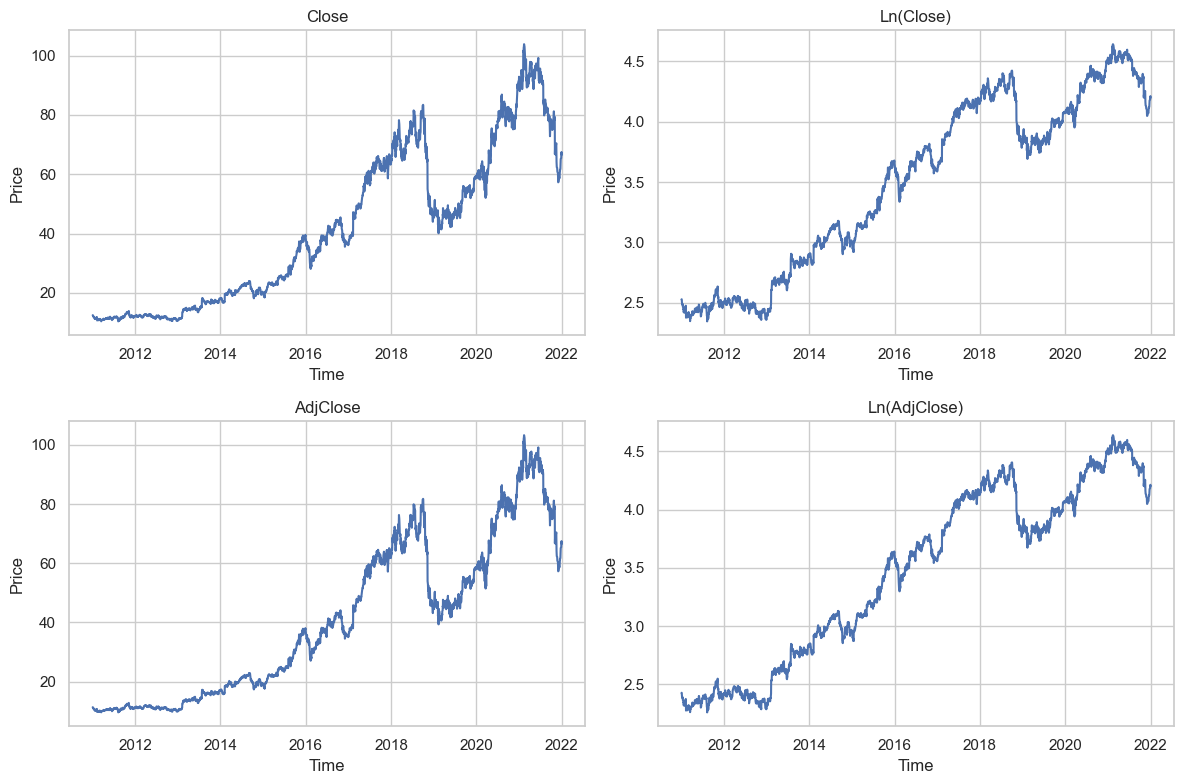

In [111]:
#Visualization of data
# Set up 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Top-left: Close
axs[0, 0].plot(df.index, df["Close"])
axs[0, 0].set_title("Close")
axs[0, 0].set_xlabel("Time")
axs[0, 0].set_ylabel("Price")

# Top-right: Ln(Close)
axs[0, 1].plot(df.index, np.log(df["Close"]))
axs[0, 1].set_title("Ln(Close)")
axs[0, 1].set_xlabel("Time")
axs[0, 1].set_ylabel("Price")

# Bottom-left: Adjusted Close
axs[1, 0].plot(df.index, df["Adjusted"])
axs[1, 0].set_title("AdjClose")
axs[1, 0].set_xlabel("Time")
axs[1, 0].set_ylabel("Price")

# Bottom-right: Ln(AdjClose)
axs[1, 1].plot(df.index, np.log(df["Adjusted"]))
axs[1, 1].set_title("Ln(AdjClose)")
axs[1, 1].set_xlabel("Time")
axs[1, 1].set_ylabel("Price")

# Adjust layout
plt.tight_layout()

# ✅ Save to file
output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)

plt.savefig(f"{output_folder}/price_plots.png", dpi=300)

plt.show()

The patterns do not appear to exhibit significant differences in terms of their behavior, as per the Random Walk (RW) style analysis. However, there are variations in the values.

To mitigate the impact of dividends, we will analyze the adjusted values, which account for the dividend effect.

We will employ a logarithmic scale for the following reasons:

- allows for a clearer visualization of changes and fluctuations.

- because it aligns returns with prices on a logarithmic scale, as they
  represent the first differences of logarithmic prices
  (log(Close).diff())).
  
From this point onward, our analysis will focus on log(Adjusted) values.

In [112]:
df["Adjusted_log"]=np.log(df["Adjusted"])
df["Close_log"]=np.log(df["Close"])

The Figures are showing a trend of “adjusted” prices, the one on the right is in a logarithmic scale often preferred because it better captures the variations. A growing trend emerges interrupted by negative phases in 2019 and 2021.

The data appear to be non-stationary, a fact confirmed by below analysis of ACF and PACF graphs.

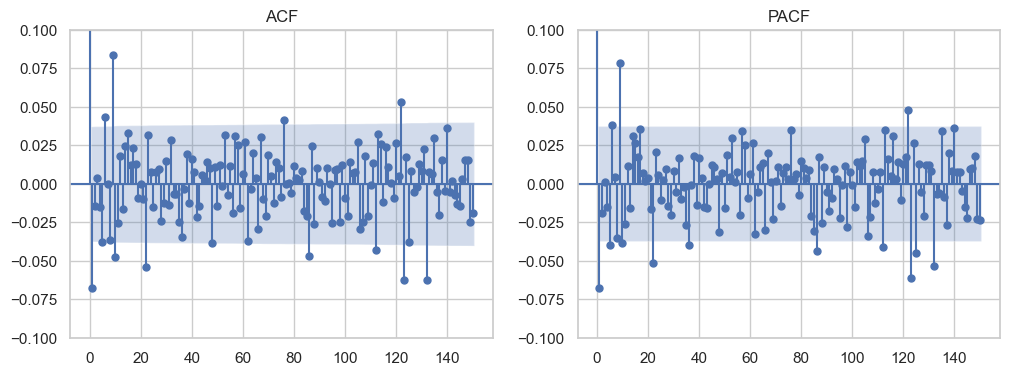

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(np.array(df["Adjusted_log"].diff())[1:], lags=150, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(np.array(df["Adjusted_log"].diff())[1:], lags=150, ax=axes[1],method='yw') # PACF
axes[1].set_title("PACF") 
axes[1].set_ylim([-0.1,0.1])

# ✅ Save to file
output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)

plt.savefig(f"{output_folder}/ACF_PACF_Adjusted_log.png", dpi=300)
plt.show()

However, unlike in the original project this doesn't seem like an AR(1) process!

In [114]:
#ADF test with trend
TSA_Finance_Functions.adf_test(df["Adjusted_log"], max_aug=20, version='t') 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-1.9857330255,-3.9630000000,-3.4130000000,-3.1280000000,0.0038000000,0.0000000000,0.0000000000
1,1,-1.7968980169,-3.9630000000,-3.4130000000,-3.1280000000,0.3228000000,0.0001000000,0.0002000000
2,2,-1.7282890814,-3.9630000000,-3.4130000000,-3.1280000000,0.4879000000,0.0002000000,0.0003000000
3,3,-1.7292768609,-3.9630000000,-3.4130000000,-3.1280000000,0.1952000000,0.0002000000,0.0002000000
4,4,-1.6768115784,-3.9630000000,-3.4130000000,-3.1280000000,0.1444000000,0.0003000000,0.0003000000
5,5,-1.5583455540,-3.9630000000,-3.4130000000,-3.1280000000,0.0031000000,0.0005000000,0.0008000000
6,6,-1.6617631666,-3.9630000000,-3.4130000000,-3.1280000000,0.0003000000,0.0024000000,0.0023000000
7,7,-1.6758449158,-3.9630000000,-3.4130000000,-3.1280000000,0.0002000000,0.0002000000,0.0017000000
8,8,-1.5812564408,-3.9630000000,-3.4130000000,-3.1280000000,0.0002000000,0.0027000000,0.0020000000
9,9,-1.7943383888,-3.9630000000,-3.4130000000,-3.1280000000,0.1978000000,0.0756000000,0.2133000000


In [115]:
#interpretation of table: assuming that p-value is 5%, then we will analyse 9th lag 
#(then, in BG test, null hypothesis of no autocorrelation of residuals upholds)

#Looking at ADF test statistic we can conclude that 'Adjusted_log' variable is non-stationary (ADF test statistic doesn't 'fall' 
#into critical value interval).

#As a result, we need to analyse first difference of 'Adjusted_log' variable!

In [116]:
#ADF test for first differences
TSA_Finance_Functions.adf_test(df["Adjusted_log"].diff(), max_aug=20, version='t')

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-56.2647404473,-3.9630000000,-3.4130000000,-3.1280000000,0.2629000000,0.0001000000,0.0002000000
1,1,-39.1498693455,-3.9630000000,-3.4130000000,-3.1280000000,0.4230000000,0.0002000000,0.0003000000
2,2,-31.3510866693,-3.9630000000,-3.4130000000,-3.1280000000,0.2330000000,0.0002000000,0.0002000000
3,3,-27.3311339545,-3.9630000000,-3.4130000000,-3.1280000000,0.1168000000,0.0003000000,0.0004000000
4,4,-25.2325198086,-3.9630000000,-3.4130000000,-3.1280000000,0.0034000000,0.0005000000,0.0010000000
5,5,-21.8917454472,-3.9630000000,-3.4130000000,-3.1280000000,0.0004000000,0.0024000000,0.0026000000
6,6,-20.1057660968,-3.9630000000,-3.4130000000,-3.1280000000,0.0002000000,0.0002000000,0.0020000000
7,7,-19.4254632397,-3.9630000000,-3.4130000000,-3.1280000000,0.0002000000,0.0035000000,0.0027000000
8,8,-16.8581380447,-3.9630000000,-3.4130000000,-3.1280000000,0.1824000000,0.0891000000,0.2402000000
9,9,-16.6793587283,-3.9630000000,-3.4130000000,-3.1280000000,0.5333000000,0.4416000000,0.6132000000


In [117]:
#interpretation of table: assuming that p-value is 5%, then we will analyse again 9th lag 
#(then, in BG test, null hypothesis of no autocorrelation of residuals upholds)

#Looking at ADF test statistic we can conclude that first differences of variable are stationary (ADF test statistic 'falls' 
#into critical value interval).

#As a result, we can conclude that 'Adjusted_log' is a ~I(1) process.
#This conclusion is typical in time series of daily prices of financial assets

## Preliminary analysis of log-returns

In [118]:
# Percentage log-returns
df['yret'] = 100 * df['cc_ret']

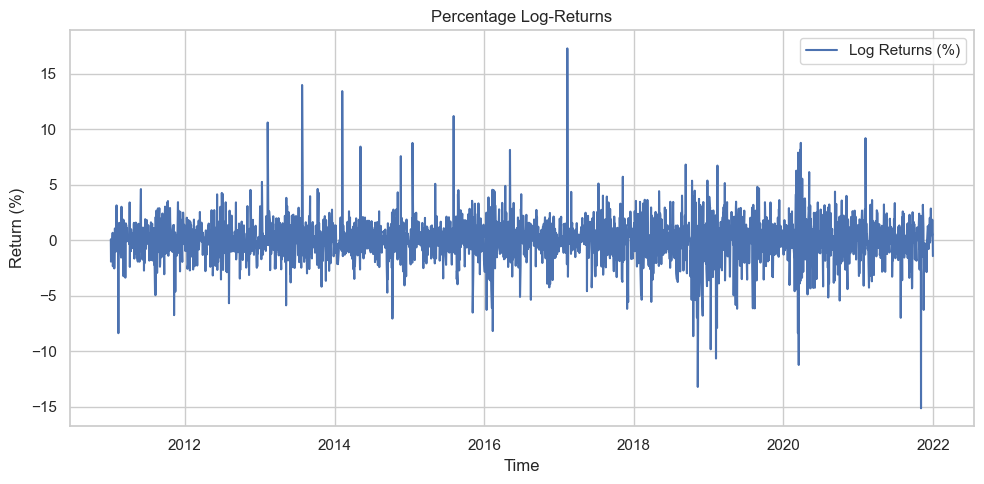

In [119]:
#Plot for variable
plt.figure(figsize=(10, 5))
plt.plot(df['yret'], label="Log Returns (%)")
plt.title("Percentage Log-Returns")
plt.xlabel("Time")
plt.ylabel("Return (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# ✅ Save to file
output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)

plt.savefig(f"{output_folder}/Log_returns_plot.png", dpi=300)
plt.show()

Comments: 
1) Daily returns move around a mean close to zero similarly to a White Noise process with a lot of heteroskedactisity and mean close to 0
2) There are periods with different variability around the mean (sometimes high, sometimes low) -> volatility clustering will be necessary
3) Data doesn't seem to have been affected by the Covid-19 crisis (argueable)

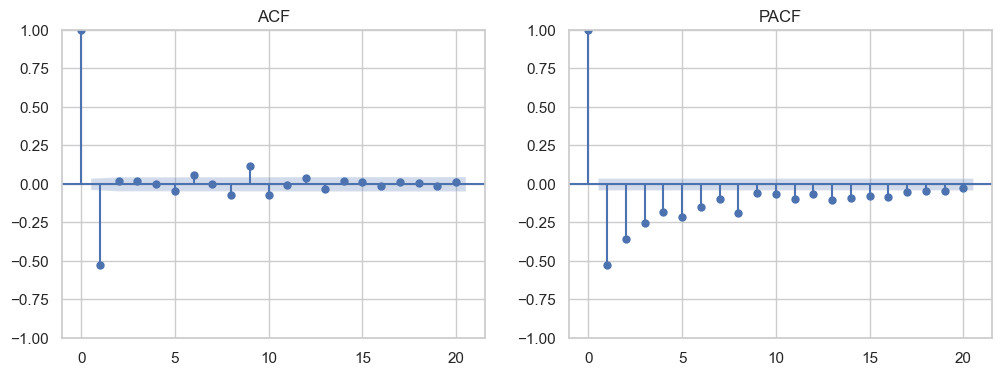

In [120]:
# Ensure no NaNs are passed to the plots
yret_clean = df['yret'].dropna().diff().dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 

# ACF
plot_acf(yret_clean, lags=20, ax=axes[0]) #change of lag and limits for petter visualisation
axes[0].set_title("ACF")

# PACF
plot_pacf(yret_clean, lags=20, ax=axes[1], method='yw')
axes[1].set_title("PACF")

# Save before show

output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)
plt.savefig(f"{output_folder}/ACF_PACF_log_returns.png", dpi=300)

plt.show()

Comments:

    Daily returns move around a mean close to zero similarly to a White Noise process with a lot of heteroskedactisity and mean close to 0
    There are periods with different variability around the mean (sometimes high, sometimes low) -> volatility clustering will be necessary
    Data doesn't seem to have been affected by the Covid-19 crisis (argueable)

In [121]:
# Ljung-Box statistics on log-returns
# Set parameters
npar = 0
lags = [2, 5, 10, 15, 20, 30, 50]  # already includes npar=0

# Run Ljung-Box test
lb_test = acorr_ljungbox(yret_clean, lags=lags, return_df=True)

# Optionally extract and print key rows
lb_result = lb_test[['lb_stat', 'lb_pvalue']]
lb_result.index = [f"Lag {lag}" for lag in lags]
print(lb_result)

              lb_stat    lb_pvalue
Lag 2  763.9852302049 0.0000000000
Lag 5  771.3242038738 0.0000000000
Lag 10 847.8017124370 0.0000000000
Lag 15 856.3920861044 0.0000000000
Lag 20 858.1956269723 0.0000000000
Lag 30 882.4216090506 0.0000000000
Lag 50 910.4323634375 0.0000000000


Comment: All lags statistically significant but it is quite uncommon 

A further check should be do an ADF test on returns to check whether it is also a ~I(1) process

In [122]:
#ADF test with trend
TSA_Finance_Functions.adf_test(df["yret"], max_aug=20, version='t')

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-56.2647404473,-3.9630000000,-3.4130000000,-3.1280000000,0.2629000000,0.0001000000,0.0002000000
1,1,-39.1498693455,-3.9630000000,-3.4130000000,-3.1280000000,0.4230000000,0.0002000000,0.0003000000
2,2,-31.3510866693,-3.9630000000,-3.4130000000,-3.1280000000,0.2330000000,0.0002000000,0.0002000000
3,3,-27.3311339545,-3.9630000000,-3.4130000000,-3.1280000000,0.1168000000,0.0003000000,0.0004000000
4,4,-25.2325198086,-3.9630000000,-3.4130000000,-3.1280000000,0.0034000000,0.0005000000,0.0010000000
5,5,-21.8917454472,-3.9630000000,-3.4130000000,-3.1280000000,0.0004000000,0.0024000000,0.0026000000
6,6,-20.1057660968,-3.9630000000,-3.4130000000,-3.1280000000,0.0002000000,0.0002000000,0.0020000000
7,7,-19.4254632397,-3.9630000000,-3.4130000000,-3.1280000000,0.0002000000,0.0035000000,0.0027000000
8,8,-16.8581380447,-3.9630000000,-3.4130000000,-3.1280000000,0.1824000000,0.0891000000,0.2402000000
9,9,-16.6793587283,-3.9630000000,-3.4130000000,-3.1280000000,0.5333000000,0.4416000000,0.6132000000


In [123]:
#interpretation of table: assuming that p-value is 5%, then we will analyse again 8th lag 
#(then, in BG test, null hypothesis of no autocorrelation of residuals upholds)

#Looking at ADF test statistic we can conclude that 'yret' variable is stationary (ADF test statistic 'falls' 
#into critical value interval).

#As a result, we can conclude that 'yret' is actually a ~I(0) process, as in original report

In here, the authors conduct test of independence of returns with BDS test- unfortunately it is not implemented in arch Python package, therefore we cocnluded on the previously performed Ljung-Box test

## ARCH test on demeaned log-returns

In [124]:
yret_demeaned = yret_clean - yret_clean.mean()

lags = [4, 8, 12, 16]

results = []
for lag in lags:
    test_stat, p_value, _, _ = het_arch(yret_demeaned, nlags=lag)
    results.append({'lag': lag, 'arch_stat': test_stat, 'p_value': p_value})

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results)
print(results_df.head(3))  # equivalent to R's at[1:3,]

   lag      arch_stat      p_value
0    4 763.5630539395 0.0000000000
1    8 785.2001120865 0.0000000000
2   12 789.1451229807 0.0000000000


Results: variables largely significant at all lags indicates the fact that there is no IID ? Authors with similar results conclude that returns are heteroskedastic

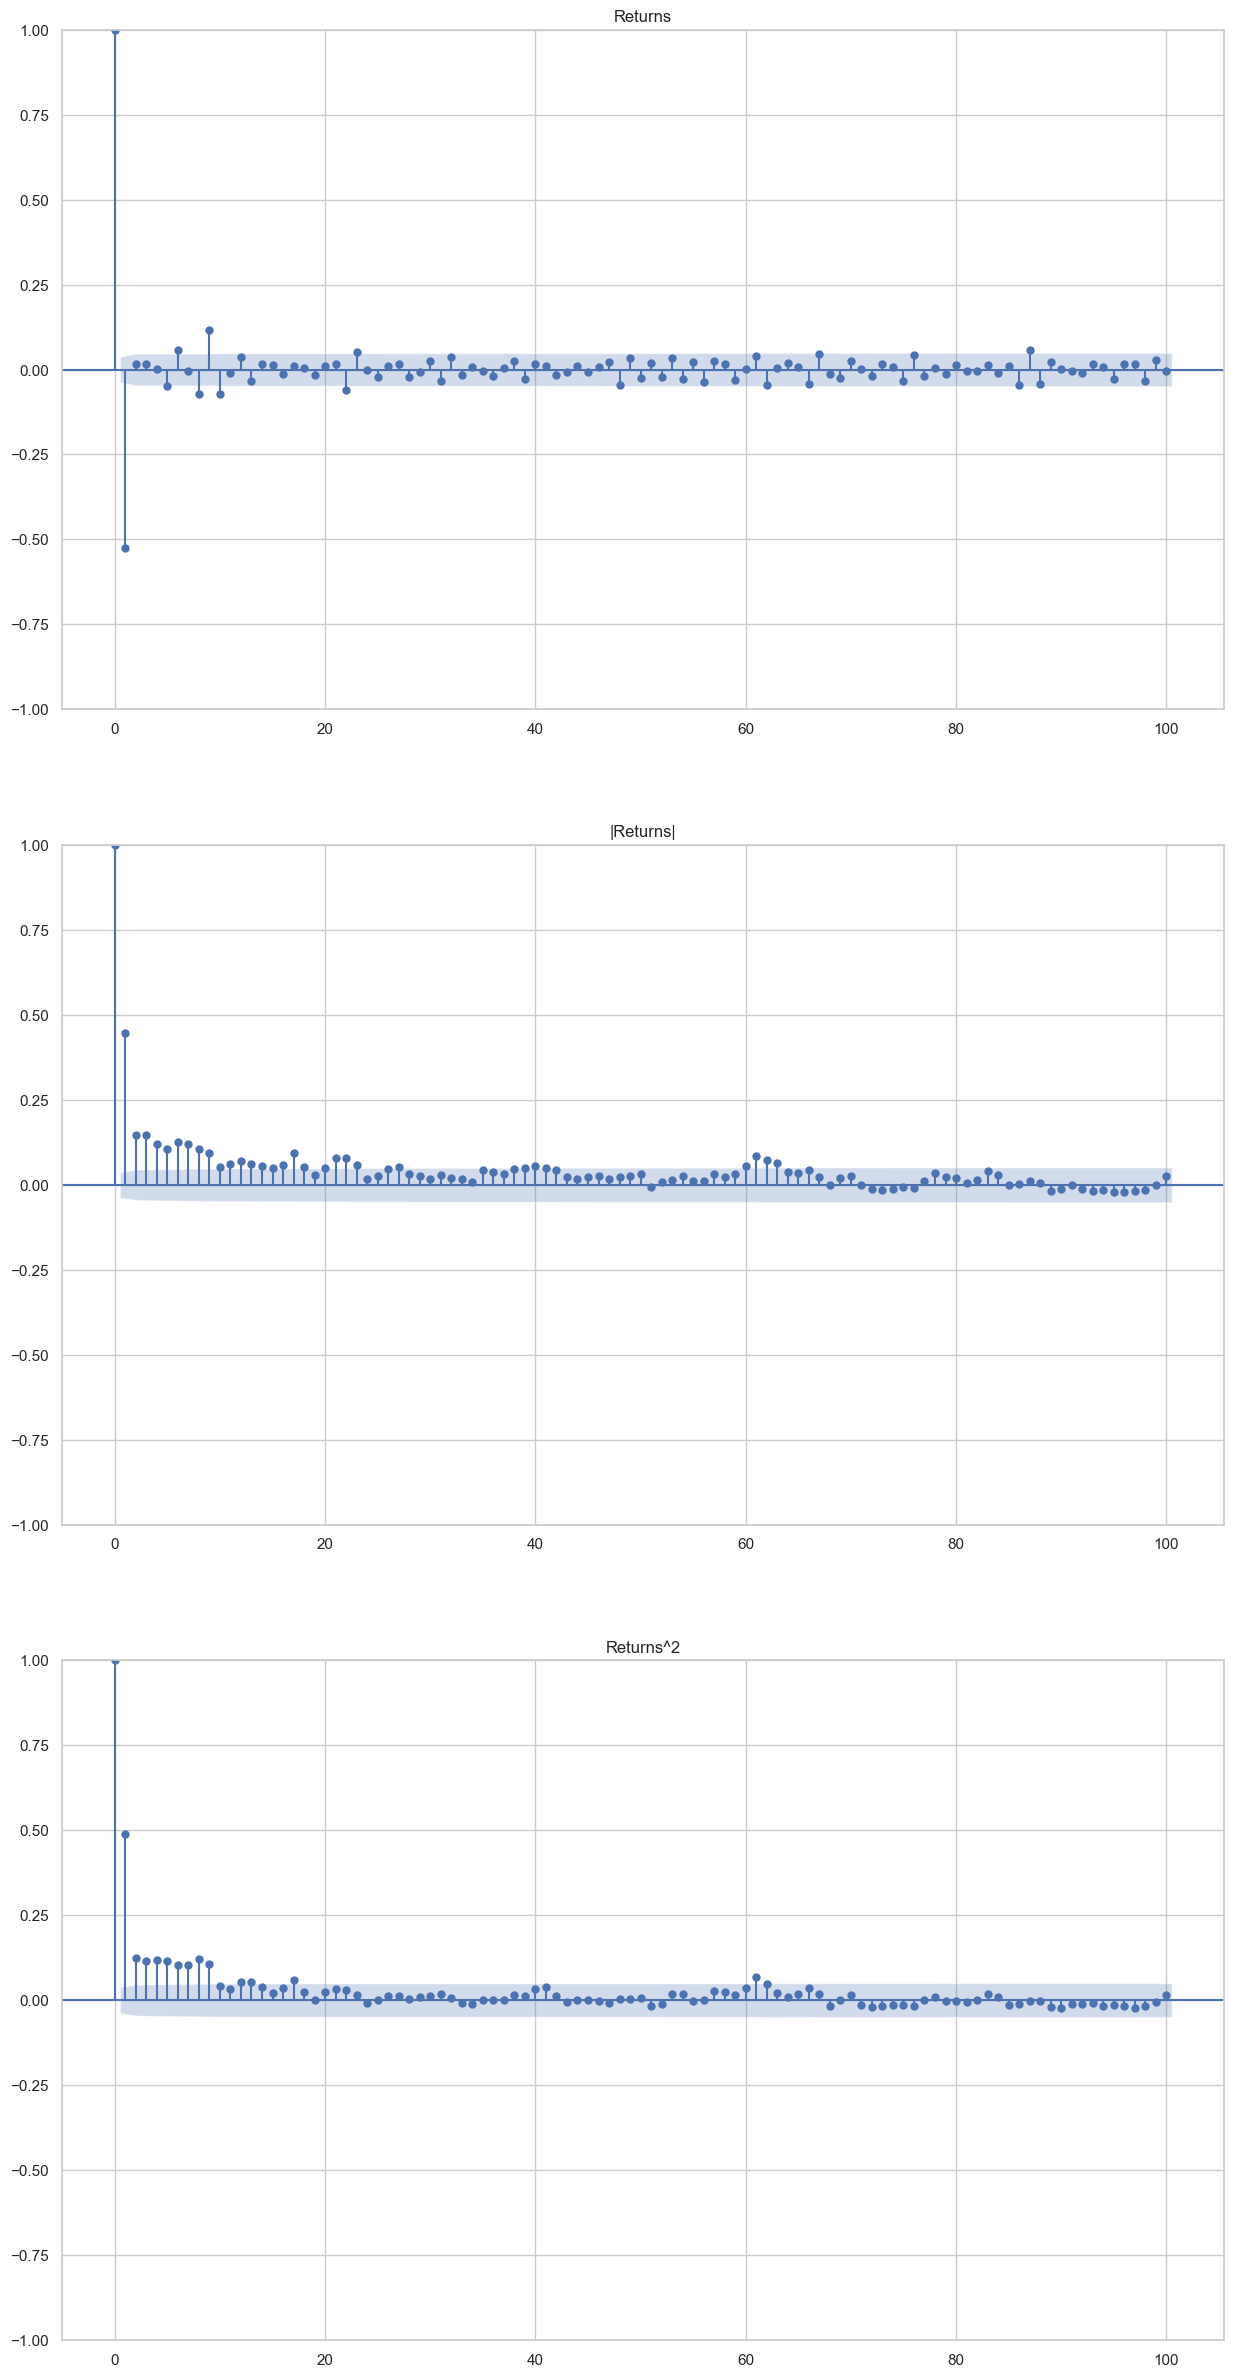

In [125]:
# ACF of residuals, abs residuals and squared residuals
fig, axes = plt.subplots(3, 1, figsize=(15,30)) 

# ACF
plot_acf(yret_clean, lags=100, ax=axes[0]) #change of lag and limits for petter visualisation
axes[0].set_title("Returns")

plot_acf(abs(yret_clean), lags=100, ax=axes[1]) 
axes[1].set_title("|Returns|")

plot_acf(yret_clean*yret_clean, lags=100, ax=axes[2]) 
axes[2].set_title("Returns^2")

# Save before show
output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)
plt.savefig(f"{output_folder}/ACF_returns_abs_squared.png", dpi=300)

plt.show()

Plots slightly differs from the ones provided by authors, but nevertheless returns of all types show very slow decay #spojrzeć
This certifies volatility clustering in terms of autocorrelation-Heteroscedasticity
(it is more visible for absolute nad squared returns)

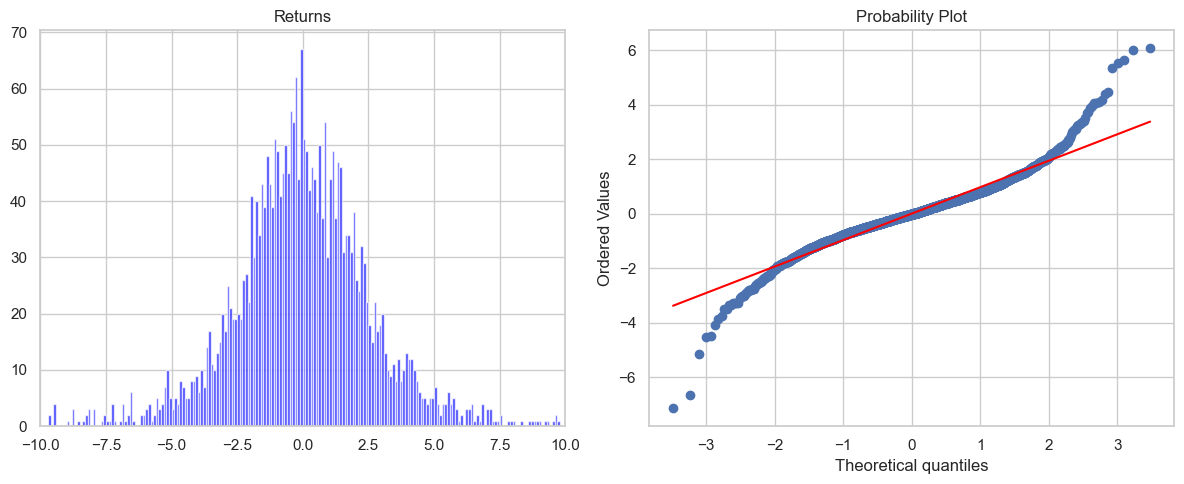

In [126]:
#Unconditional distribution with pre-build functions
# Scale (standardize) yret_clean
scaler = StandardScaler()
yret_scaled = scaler.fit_transform(yret_clean.values.reshape(-1, 1)).flatten()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
axs[0].hist(yret_clean, bins=200, range=(-10, 10), color='blue', alpha=0.7)
axs[0].set_title('Returns')
axs[0].set_xlim(-10, 10)

# QQ-plot
probplot(yret_scaled, plot=axs[1])
axs[1].get_lines()[1].set_color('red')  # line color

# ✅ Save to file
output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)

plt.savefig(f"{output_folder}/Hist_and_QQ_returns.png", dpi=300)

plt.tight_layout()
plt.show()

In [127]:
# Jarque-Bera statistics on log-returns
jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(df["yret"].dropna())

print(f"Jarque-Bera test statistic: {jb_stat:.4f}")
print(f"P-value: {jb_pvalue:.4f}")
print(f"Skewness: {skew:.4f}")
print(f"Kurtosis: {kurtosis:.4f}")

Jarque-Bera test statistic: 8411.2425
P-value: 0.0000
Skewness: 0.0277
Kurtosis: 11.5397


Comment: Normality is highly rejected; the distribution is leptokurtic. Unconditional return distribution suggests
strong hypernormality (large tails) -> another volatility certification, distribution more similar to t-student than normal

## ARIMA MODELLING

Autors conclude that the best suited ARMA model on returns is ARMA(1,0), with standardized
student t distribution of errors (basing on ACF plots for returns, |returns| and returns^2)- let's see if we will obtain same results!

In order to analyse it, we will use specially designed 'statsmodels.tsa.arima.model' package

In [128]:
#ARIMA (1,0,0) on log-returns
# Definition of ARIMA model
model = ARIMA(yret_clean.values, order=([1], 0, 0)) #square bracket important

# Fitting the model
arima100_ = model.fit()

# Summary
print(arima100_.summary()) 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2767
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -6408.872
Date:                Mon, 02 Jun 2025   AIC                          12823.743
Time:                        11:41:21   BIC                          12841.520
Sample:                             0   HQIC                         12830.164
                               - 2767                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.409e-05      0.031     -0.002      0.999      -0.060       0.060
ar.L1         -0.5249      0.009    -56.287      0.000      -0.543      -0.507
sigma2         6.0157      0.087     68.880      0.0

Unlike in R, the Coefficients Matrix and Robust Coefficients Matrix don't need to be calculated- by using .summary() function for specific model, it is already provided and no input from user is required!

In [129]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(arima100_.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test) #

          lb_stat    lb_pvalue
5  426.7633171627 0.0000000000
10 480.2639115087 0.0000000000
15 491.7788859070 0.0000000000
20 493.9053782079 0.0000000000
25 513.4739511266 0.0000000000


Comment: the residuals are not autocorrelated for each lag. The model is theoretically correct and it alligns with the result of original research!

In [130]:
# Information Criteria of model
fit0 = ARIMA(yret_clean.values, order=(1,0,0)).fit()
info_criteria = {
    'AIC': fit0.aic,
    'BIC': fit0.bic,
    'HQIC': fit0.hqic
}

# --- Convert to a matrix (1-row DataFrame) ---
info_matrix = pd.DataFrame([info_criteria])

# Optional: Add model order as a column
info_matrix['Model'] = 'ARMA (1,0)'

# Reorder columns
info_matrix = info_matrix[['Model', 'AIC', 'BIC','HQIC']]

# --- Display ---
print(info_matrix)

        Model              AIC              BIC             HQIC
0  ARMA (1,0) 12823.7434345974 12841.5199915367 12830.1639614215


Unlike in paper, the error seems to be robust and therefore, a better model should be applied. Authors also change the distribution of residuals in model (for t-studen instead of Standard Normal distribution), but unfortunately there is no such built-in function within ARIMA or arch Python package (potential for further improvement)

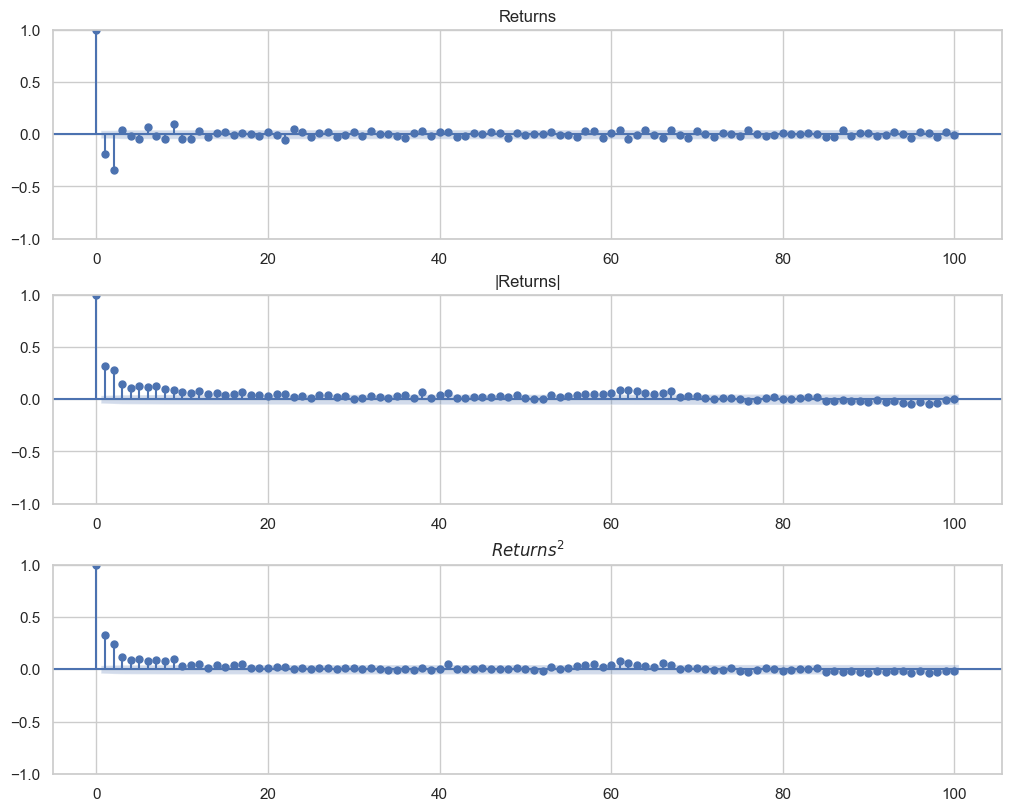

In [131]:
# ACF of residuals, abs residuals and squared residuals within ARMA(1,0) model

# Extract residuals as numpy array
res = fit0.resid

fig, axs = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True)

# Plot ACF of residuals
plot_acf(res, lags=100, ax=axs[0], title="Returns")

# Plot ACF of absolute residuals
plot_acf(np.abs(res), lags=100, ax=axs[1], title="|Returns|")

# Plot ACF of squared residuals
plot_acf(res**2, lags=100, ax=axs[2], title=r"$Returns^2$")

output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)
plt.savefig(f"{output_folder}/ACF_PACF_ARMA(1,0).png", dpi=300)

plt.show()

## ARCH and GARCH modelling

In order to model volatility, various GARCH-type models are adopted (described in README file).
Firstly, we will analyse simple-GARCH (sGARCH) framework and its performance

Following to the findings of authors, we will proceed with GARCH(1,1) + ARMA(1,0) model, with residuals from t-Student distribution.

### Simple GARCH (sGARCH) and TGARCH model

In [132]:
#TGARCH on log returns
# Define GARCH(1,1) with ARMA(1,0) mean and Student's t errors
TGARCH = arch_model(yret_clean.values, mean='AR', lags=1, vol='Garch', p=1, q=1, dist='t')

# Fit the model
fit1 = TGARCH.fit(disp='off')  # disp='off' suppresses output

# Number of estimated parameters
np1 = len(fit1.params)

#Manual calculation of HQIC criteria (not included in the used package)
logL = fit1.loglikelihood
k = len(fit1.params)
n = fit1.nobs

hqic = -2 * logL + 2 * k * np.log(np.log(n))

# Print information criteria
print("\nInformation Criteria")
print(f"AIC: {fit1.aic}")
print(f"BIC: {fit1.bic}")
print(f"HQIC: {hqic}")

# Optional: Print summary
print(fit1.summary())


Information Criteria
AIC: 12076.354955378709
BIC: 12111.905900452057
HQIC: 12089.195461717814
                              AR - GARCH Model Results                              
Dep. Variable:                            y   R-squared:                       0.276
Mean Model:                              AR   Adj. R-squared:                  0.275
Vol Model:                            GARCH   Log-Likelihood:               -6032.18
Distribution:      Standardized Student's t   AIC:                           12076.4
Method:                  Maximum Likelihood   BIC:                           12111.9
                                              No. Observations:                 2766
Date:                      Mon, Jun 02 2025   Df Residuals:                     2764
Time:                              11:41:23   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       9

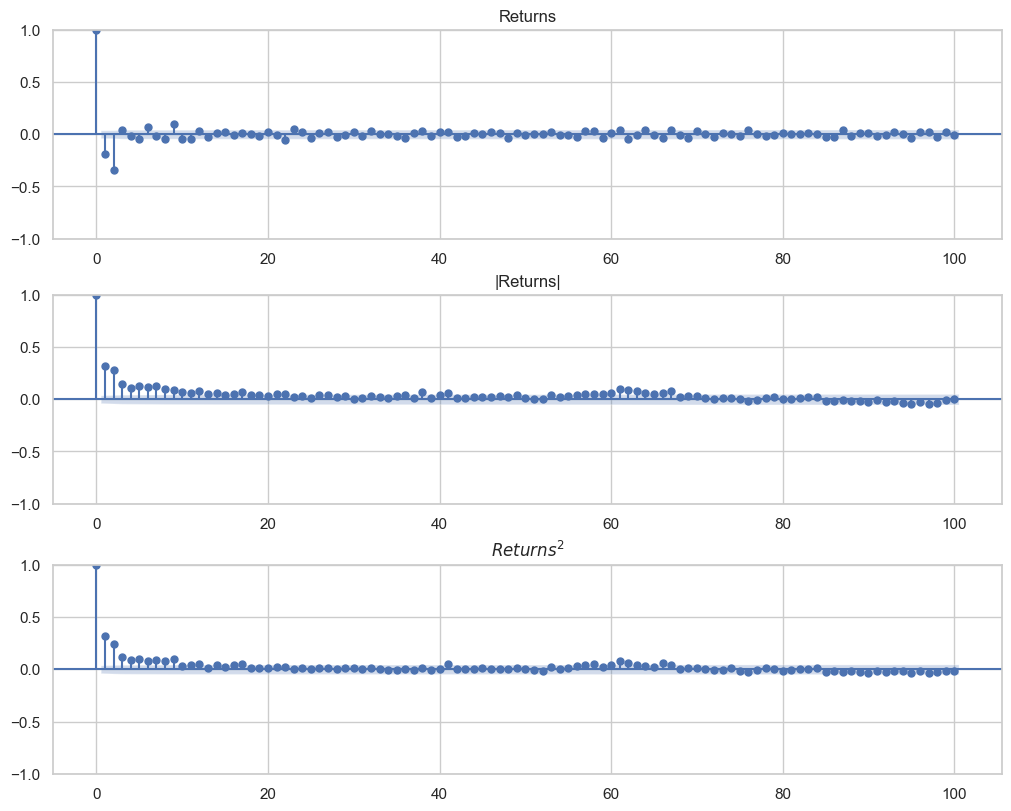

In [133]:
# ACF of residuals, abs residuals and squared residuals within ARMA(1,0) model

# Extract residuals
res = fit1.resid
res = res[~np.isnan(res)]  # Remove any NaNs

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True)

plot_acf(res, lags=100, ax=axs[0])
axs[0].set_title("Returns")

plot_acf(np.abs(res), lags=100, ax=axs[1])
axs[1].set_title("|Returns|")

plot_acf(res**2, lags=100, ax=axs[2])
axs[2].set_title(r"$Returns^2$")

# Save figure

output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)
plt.savefig(f"{output_folder}/ACF_PACF_TGARCH.png", dpi=300)

plt.show()

In [134]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(res, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test) #H0: lack of autocorrelation

          lb_stat    lb_pvalue
5  427.4409422947 0.0000000000
10 480.9326046332 0.0000000000
15 492.5139892838 0.0000000000
20 494.6518220694 0.0000000000
25 514.3511282435 0.0000000000


In [135]:
#Ljung-Box test for autocorrelation of each kind of residuals
# Ljung-Box test (raw residuals)
ljung_raw = acorr_ljungbox(res, lags=[10, 20], return_df=True)

# Ljung-Box test (absolute residuals)
ljung_abs = acorr_ljungbox(np.abs(res), lags=[10, 20], return_df=True)

# Ljung-Box test (squared residuals)
ljung_sq = acorr_ljungbox(res**2, lags=[10, 20], return_df=True)

# Display results
print("Ljung-Box Test on Standardized Residuals")
print(ljung_raw, '\n')

print("Ljung-Box Test on Absolute Standardized Residuals")
print(ljung_abs, '\n')

print("Ljung-Box Test on Squared Standardized Residuals")
print(ljung_sq)


Ljung-Box Test on Standardized Residuals
          lb_stat    lb_pvalue
10 480.9326046332 0.0000000000
20 494.6518220694 0.0000000000 

Ljung-Box Test on Absolute Standardized Residuals
          lb_stat    lb_pvalue
10 768.9447420209 0.0000000000
20 854.0719046503 0.0000000000 

Ljung-Box Test on Squared Standardized Residuals
          lb_stat    lb_pvalue
10 615.1573734797 0.0000000000
20 645.2104592198 0.0000000000


The autors also analyze a same GARCH framework with residuals from standard normal- let's compare the result

In [136]:
#sGARCH with standard residuals
# Define GARCH(1,1) with ARMA(1,0) mean and standard normal errors
sGARCH_std = arch_model(yret_clean.values, mean='AR', lags=1, vol='Garch', p=1, q=1, dist='normal')

# Fit the model
fit2 = sGARCH_std.fit(disp='off')  # disp='off' suppresses output

# Number of estimated parameters
np1 = len(fit2.params)

#Manual calculation of HQIC criteria (not included in the used package)
logL = fit2.loglikelihood
k = len(fit2.params)
n = fit2.nobs

hqic = -2 * logL + 2 * k * np.log(np.log(n))

# Print information criteria
print("\nInformation Criteria")
print(f"AIC: {fit2.aic}")
print(f"BIC: {fit2.bic}")
print(f"HQIC: {hqic}")

# Optional: Print summary
print(fit2.summary())


Information Criteria
AIC: 12337.540939744764
BIC: 12367.166727305887
HQIC: 12348.241361694018
                           AR - GARCH Model Results                           
Dep. Variable:                      y   R-squared:                       0.275
Mean Model:                        AR   Adj. R-squared:                  0.275
Vol Model:                      GARCH   Log-Likelihood:               -6163.77
Distribution:                  Normal   AIC:                           12337.5
Method:            Maximum Likelihood   BIC:                           12367.2
                                        No. Observations:                 2766
Date:                Mon, Jun 02 2025   Df Residuals:                     2764
Time:                        11:41:25   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------

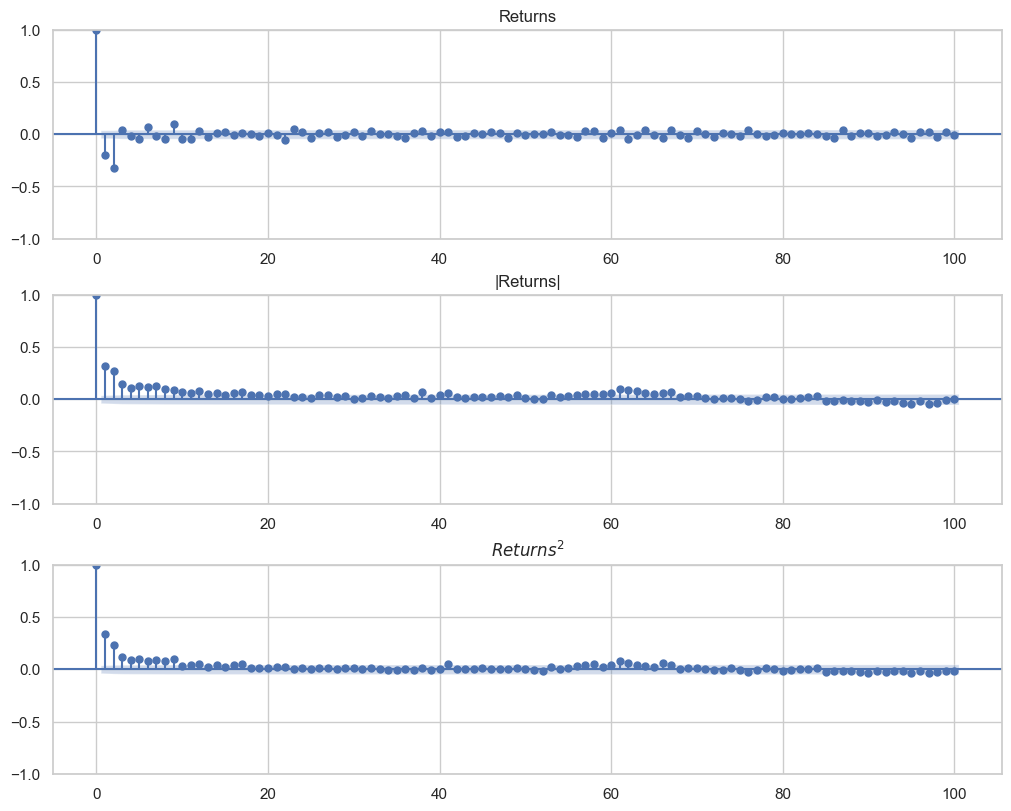

In [137]:
# ACF of residuals, abs residuals and squared residuals within ARMA(1,0) model

# Extract residuals
res_std = fit2.resid
res_std = res_std[~np.isnan(res_std)]  # Remove any NaNs

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True)

plot_acf(res_std, lags=100, ax=axs[0])
axs[0].set_title("Returns")

plot_acf(np.abs(res_std), lags=100, ax=axs[1])
axs[1].set_title("|Returns|")

plot_acf(res_std**2, lags=100, ax=axs[2])
axs[2].set_title(r"$Returns^2$")

# Save figure

output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)
plt.savefig(f"{output_folder}/ACF_PACF_sGARCH.png", dpi=300)

plt.show()

In [138]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(res_std, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test) #H0: lack of autocorrelation

          lb_stat    lb_pvalue
5  416.5644032426 0.0000000000
10 470.7108266777 0.0000000000
15 482.0576394730 0.0000000000
20 484.1754098688 0.0000000000
25 503.7624897844 0.0000000000


In [139]:
#Ljung-Box test for autocorrelation of each kind of residuals
# Ljung-Box test (raw residuals)
ljung_raw = acorr_ljungbox(res_std, lags=[10, 20], return_df=True)

# Ljung-Box test (absolute residuals)
ljung_abs = acorr_ljungbox(np.abs(res_std), lags=[10, 20], return_df=True)

# Ljung-Box test (squared residuals)
ljung_sq = acorr_ljungbox(res_std**2, lags=[10, 20], return_df=True)

# Display results
print("Ljung-Box Test on Standardized Residuals")
print(ljung_raw, '\n')

print("Ljung-Box Test on Absolute Standardized Residuals")
print(ljung_abs, '\n')

print("Ljung-Box Test on Squared Standardized Residuals")
print(ljung_sq)


Ljung-Box Test on Standardized Residuals
          lb_stat    lb_pvalue
10 470.7108266777 0.0000000000
20 484.1754098688 0.0000000000 

Ljung-Box Test on Absolute Standardized Residuals
          lb_stat    lb_pvalue
10 767.8059867852 0.0000000000
20 853.2562545928 0.0000000000 

Ljung-Box Test on Squared Standardized Residuals
          lb_stat    lb_pvalue
10 624.1180357427 0.0000000000
20 654.3237133232 0.0000000000


Authors didn't compare the models but we will analyse it a little below

In [140]:
models = [sGARCH_std, TGARCH] # list with all the models
names = ['sGARCH with std. res.', 'TGARCH'] # models' names

# Fit models and collect info
results = []

for model, name in zip(models, names):
    fit = model.fit(disp='off')
    results.append([name, round(fit.aic, 4), round(fit.bic, 4)])

# Create DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'AIC', 'BIC'])

print("Models sorted by AIC:")
print(results_df.sort_values('AIC'))

print("\nModels sorted by BIC:")
print(results_df.sort_values('BIC'))

Models sorted by AIC:
                   Model              AIC              BIC
1                 TGARCH 12076.3550000000 12111.9059000000
0  sGARCH with std. res. 12337.5409000000 12367.1667000000

Models sorted by BIC:
                   Model              AIC              BIC
1                 TGARCH 12076.3550000000 12111.9059000000
0  sGARCH with std. res. 12337.5409000000 12367.1667000000


As we can see, changing the distribution of residuals from normal standard into t-student is actually beneficial for model accuracy (this hypothesis will be tested further on, especially within forecast section of project)

In [141]:
# ARCH test: t-student residuals model
# Define lags to test
lags = [4, 8, 12, 16]
results = []
residuals_dict = {
    'TGARCH': res,
    'sGARCH with norm. std. res.': res_std
}

lags = [4, 8, 12, 16]

# Prepare an empty list to collect results
all_results = []

for name, z in residuals_dict.items():
    for lag in lags:
        test_stat, p_value, _, _ = het_arch(z, lag)
        all_results.append([name, lag, test_stat, p_value])

# Convert to DataFrame for easier viewing
arch_test_df = pd.DataFrame(all_results, columns=['Residuals', 'Lag', 'Test Statistic', 'p-value'])

print(arch_test_df)

                     Residuals  Lag  Test Statistic      p-value
0                       TGARCH    4  344.7505998459 0.0000000000
1                       TGARCH    8  358.8962260646 0.0000000000
2                       TGARCH   12  367.3596317447 0.0000000000
3                       TGARCH   16  369.6538779361 0.0000000000
4  sGARCH with norm. std. res.    4  351.6944730156 0.0000000000
5  sGARCH with norm. std. res.    8  365.7284414745 0.0000000000
6  sGARCH with norm. std. res.   12  374.1509086963 0.0000000000
7  sGARCH with norm. std. res.   16  376.6215609345 0.0000000000


The autors conclude that the variance is stable for each model and lag- we have also obtained such a result

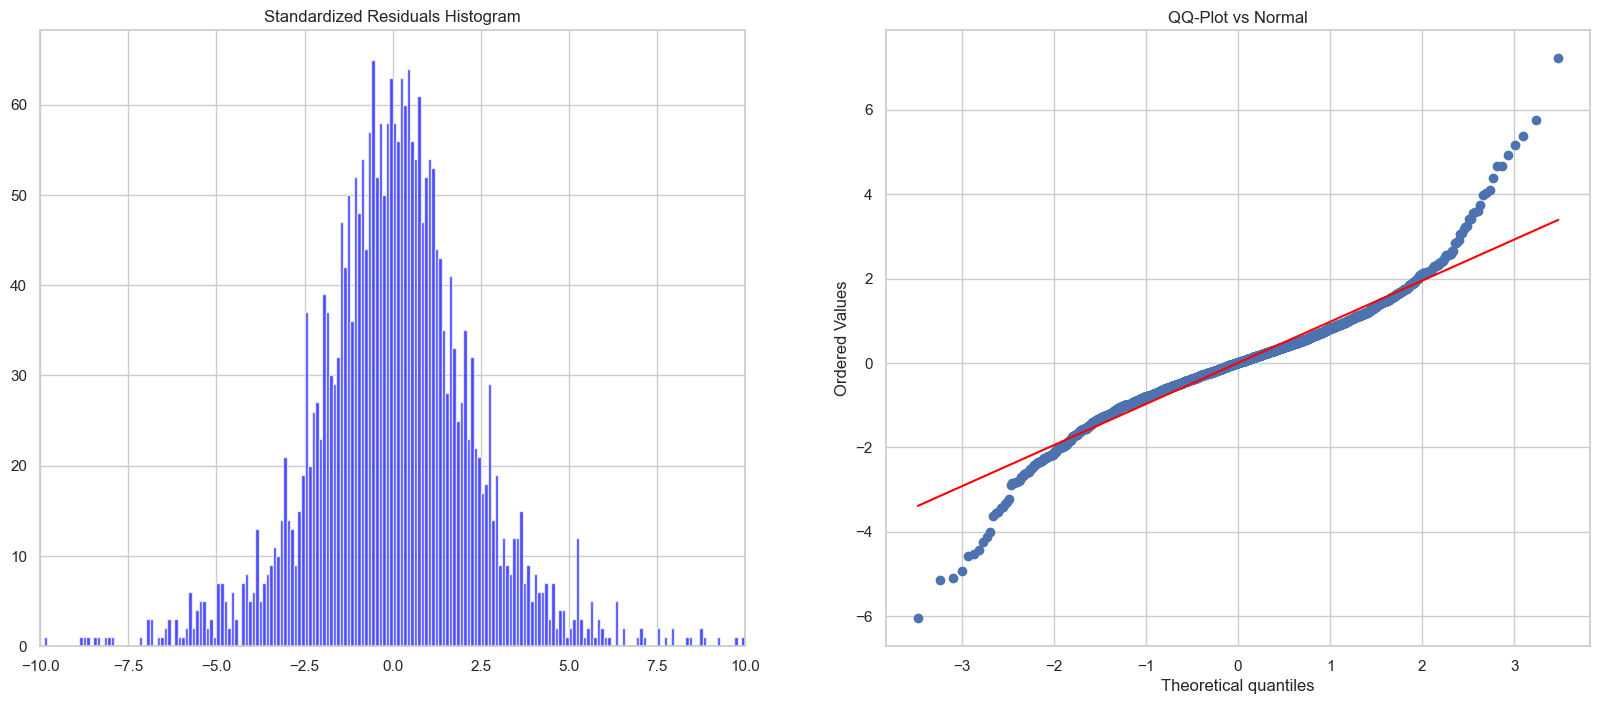

In [142]:
#sGARCH with residuals from standard normal distribution
# Scale the residuals (standardize)
scaler = StandardScaler()
res_std_scaled = scaler.fit_transform(res_std.reshape(-1, 1)).flatten()

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Histogram of standardized residuals
axs[0].hist(res_std, bins=200, range=(-10, 10), color='blue', alpha=0.7)
axs[0].set_title('Standardized Residuals Histogram')
axs[0].set_xlim(-10, 10)

# QQ-plot vs Normal
probplot(res_std_scaled, dist="norm", plot=axs[1])
axs[1].get_lines()[1].set_color('red')
axs[1].set_title("QQ-Plot vs Normal")

# Save figure
output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)
plt.savefig(f"{output_folder}/Hist_and_QQ_returns_sGARCH_std.png", dpi=300)

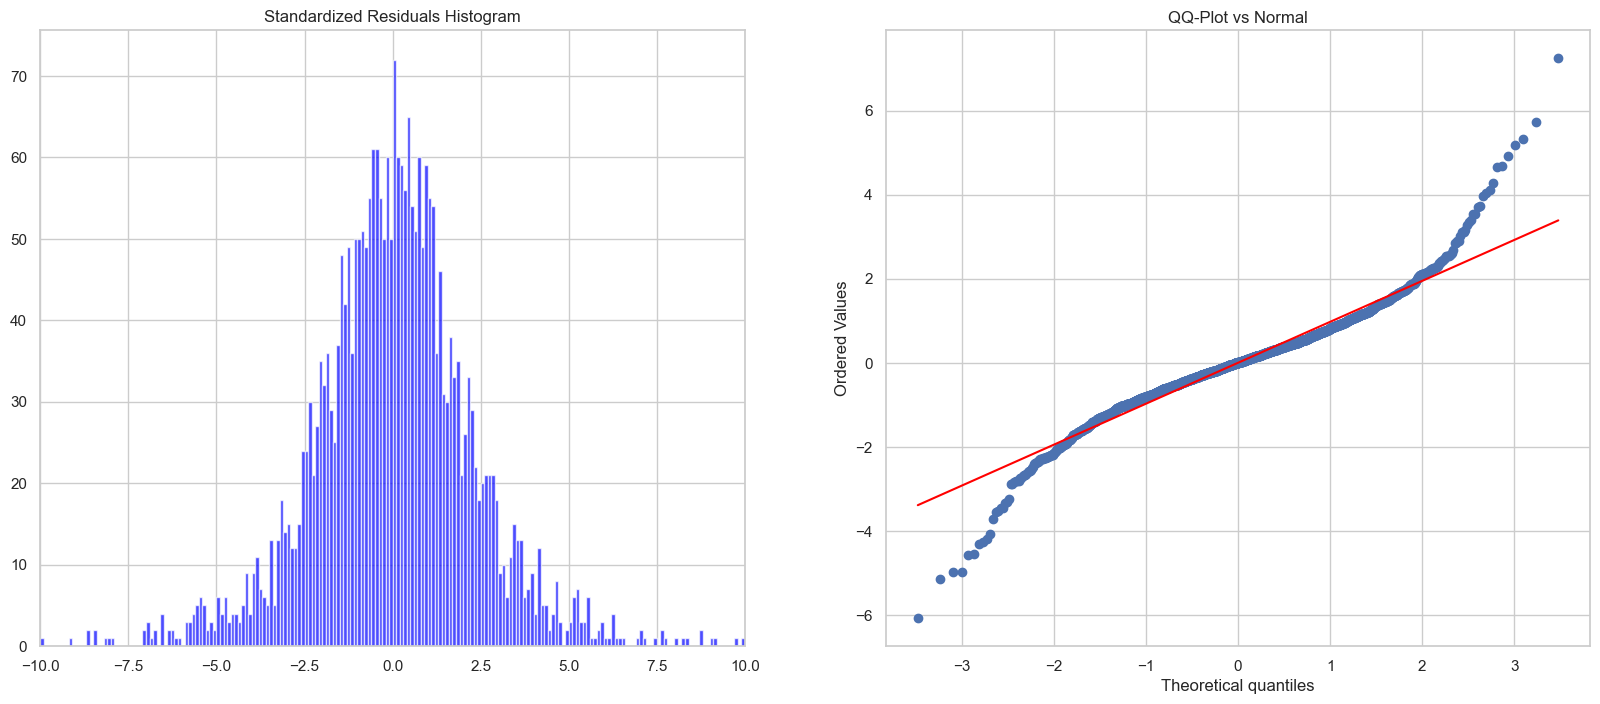

In [143]:
#sGARCH with residuals from t-student distribution
# Scale the residuals (standardize)
scaler = StandardScaler()
res_scaled = scaler.fit_transform(res.reshape(-1, 1)).flatten()

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Histogram of standardized residuals
axs[0].hist(res, bins=200, range=(-10, 10), color='blue', alpha=0.7)
axs[0].set_title('Standardized Residuals Histogram')
axs[0].set_xlim(-10, 10)

# QQ-plot vs Normal
probplot(res_scaled, dist="norm", plot=axs[1])
axs[1].get_lines()[1].set_color('red')
axs[1].set_title("QQ-Plot vs Normal")

# Save figure
output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)
plt.savefig(f"{output_folder}/Hist_and_QQ_returns_TGARCH.png", dpi=300)

In [144]:
#Leverage check for sGARCH

# Create dummy variable: 1 if residual < 0 else 0
D = (z < 0).astype(int)

# Dependent variable: squared residuals
y = res_std**2

# Add constant to regressors
X = sm.add_constant(D)

# Run OLS regression: y = beta0 + beta1*D + error
model = sm.OLS(y, X).fit()

print("\nSign bias test (manual implementation):\n")
print(model.summary())


Sign bias test (manual implementation):

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.04738
Date:                Mon, 02 Jun 2025   Prob (F-statistic):              0.828
Time:                        11:41:29   Log-Likelihood:                -11555.
No. Observations:                2766   AIC:                         2.311e+04
Df Residuals:                    2764   BIC:                         2.313e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

In [145]:
#Leverage check for TGARCH

# Create dummy variable: 1 if residual < 0 else 0
D = (z < 0).astype(int)

# Dependent variable: squared residuals
y = res**2

# Add constant to regressors
X = sm.add_constant(D)

# Run OLS regression: y = beta0 + beta1*D + error
model = sm.OLS(y, X).fit()

print("\nSign bias test (manual implementation):\n")
print(model.summary())


Sign bias test (manual implementation):

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.02394
Date:                Mon, 02 Jun 2025   Prob (F-statistic):              0.877
Time:                        11:41:29   Log-Likelihood:                -11555.
No. Observations:                2766   AIC:                         2.311e+04
Df Residuals:                    2764   BIC:                         2.313e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

Interpretation:
The coefficient on x1 (dummy for negative residuals) is -0.1307 and -0.1016 respectively, with a p-value of 0.828 and 0.866 (which is not statistically significant for assumed p > 0.05), meaning:

No evidence that negative shocks have a different impact on conditional variance than positive shocks for both models.

Therefore, no leverage effect detected by this test!

Final remarks:

Simple GARCH models (both with standard normal and t-student residuals) are already better than ARMA(1,0) and all coefficients are highly significant. Before moving on to the GJR-GARCH specification, an implementation of a model analogous to the sGARCH with the addition of a term (constant) that presents a possible asymmetric behavior of the conditional variance would be adviseable. It is necessary to test that the data actually present this asymmetric component with the tests of signs which seems to exclude an asymmetry effect.

### GJR-GARCH model

In [146]:
model_gjr = arch_model(yret_clean, vol='GARCH', p=1, q=1, o=1,  # o=1 => GJR-GARCH
                    mean='AR', lags=1, dist='t')    

fit_gjr = model_gjr.fit(disp="off") 

# Number of estimated parameters
np1 = len(fit_gjr.params)

#Manual calculation of HQIC criteria (not included in the used package)
logL = fit_gjr.loglikelihood
k = len(fit_gjr.params)
n = fit_gjr.nobs

hqic = -2 * logL + 2 * k * np.log(np.log(n))

# Print information criteria
print("\nInformation Criteria")
print(f"AIC: {fit_gjr.aic}")
print(f"BIC: {fit_gjr.bic}")
print(f"HQIC: {hqic}")

# Optional: Print summary
print(fit_gjr.summary())


Information Criteria
AIC: 12078.211872692662
BIC: 12119.687975278235
HQIC: 12093.192463421618
                            AR - GJR-GARCH Model Results                            
Dep. Variable:                         yret   R-squared:                       0.276
Mean Model:                              AR   Adj. R-squared:                  0.275
Vol Model:                        GJR-GARCH   Log-Likelihood:               -6032.11
Distribution:      Standardized Student's t   AIC:                           12078.2
Method:                  Maximum Likelihood   BIC:                           12119.7
                                              No. Observations:                 2766
Date:                      Mon, Jun 02 2025   Df Residuals:                     2764
Time:                              11:41:29   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       9

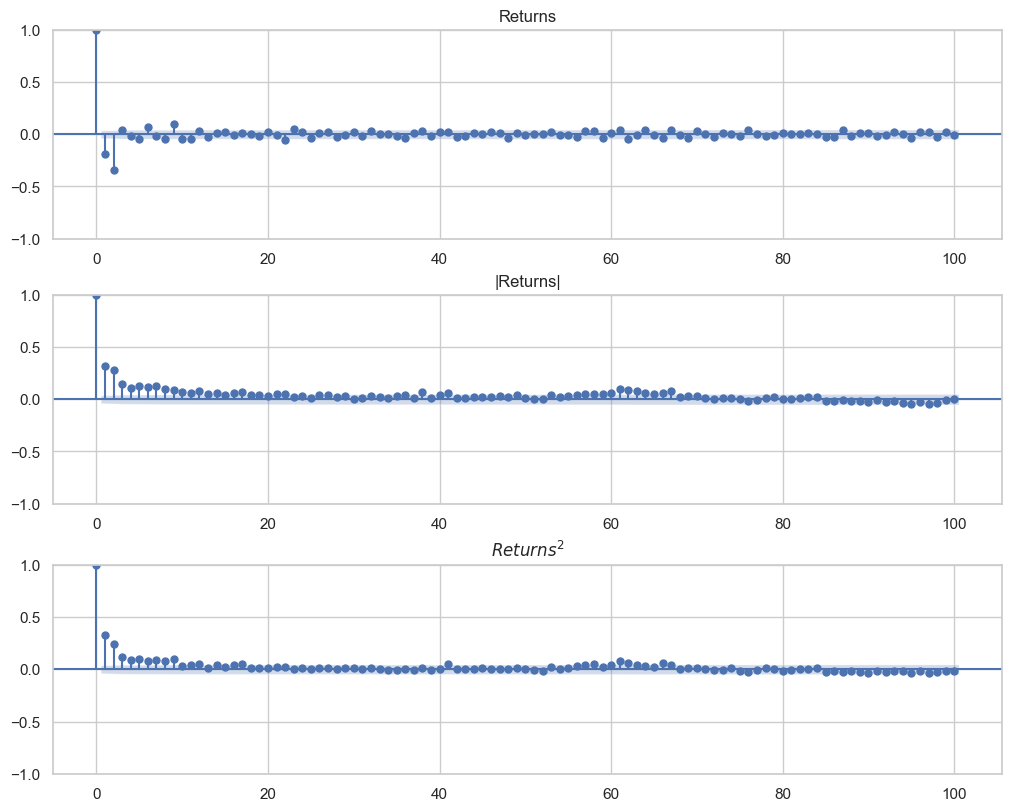

In [147]:
# ACF of residuals, abs residuals and squared residuals within GJR-GARCH

# Extract residuals
res = fit_gjr.resid
res = res[~np.isnan(res)]  # Remove any NaNs

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True)

plot_acf(res, lags=100, ax=axs[0])
axs[0].set_title("Returns")

plot_acf(np.abs(res), lags=100, ax=axs[1])
axs[1].set_title("|Returns|")

plot_acf(res**2, lags=100, ax=axs[2])
axs[2].set_title(r"$Returns^2$")

# Save figure

output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)
plt.savefig(f"{output_folder}/ACF_PACF_GJR_GARCH.png", dpi=300)

plt.show()

In [148]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(res, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test) #H0: lack of autocorrelation

          lb_stat    lb_pvalue
5  427.1903401596 0.0000000000
10 480.6958755763 0.0000000000
15 492.2721442914 0.0000000000
20 494.4095411686 0.0000000000
25 514.1063547540 0.0000000000


In [149]:
#Ljung-Box test for autocorrelation of each kind of residuals
# Ljung-Box test (raw residuals)
ljung_raw = acorr_ljungbox(res, lags=[10, 20], return_df=True)

# Ljung-Box test (absolute residuals)
ljung_abs = acorr_ljungbox(np.abs(res), lags=[10, 20], return_df=True)

# Ljung-Box test (squared residuals)
ljung_sq = acorr_ljungbox(res**2, lags=[10, 20], return_df=True)

# Display results
print("Ljung-Box Test on Standardized Residuals")
print(ljung_raw, '\n')

print("Ljung-Box Test on Absolute Standardized Residuals")
print(ljung_abs, '\n')

print("Ljung-Box Test on Squared Standardized Residuals")
print(ljung_sq)


Ljung-Box Test on Standardized Residuals
          lb_stat    lb_pvalue
10 480.6958755763 0.0000000000
20 494.4095411686 0.0000000000 

Ljung-Box Test on Absolute Standardized Residuals
          lb_stat    lb_pvalue
10 768.8059668873 0.0000000000
20 854.0759761538 0.0000000000 

Ljung-Box Test on Squared Standardized Residuals
          lb_stat    lb_pvalue
10 614.9760061038 0.0000000000
20 645.0088504900 0.0000000000


In [150]:
#GJR-GARCH with standard residuals
model_gjr_std = arch_model(yret_clean, vol='GARCH', p=1, q=1, o=1,  # o=1 => GJR-GARCH
                    mean='AR', lags=1, dist='normal')    

fit_gjr_std = model_gjr_std.fit(disp="off") 

# Number of estimated parameters
np1 = len(fit_gjr_std.params)

#Manual calculation of HQIC criteria (not included in the used package)
logL = fit_gjr_std.loglikelihood
k = len(fit_gjr_std.params)
n = fit_gjr_std.nobs

hqic = -2 * logL + 2 * k * np.log(np.log(n))

# Print information criteria
print("\nInformation Criteria")
print(f"AIC: {fit_gjr_std.aic}")
print(f"BIC: {fit_gjr_std.bic}")
print(f"HQIC: {hqic}")

# Optional: Print summary
print(fit_gjr_std.summary())


Information Criteria
AIC: 12339.53725255766
BIC: 12375.088197631008
HQIC: 12352.377758896766
                         AR - GJR-GARCH Model Results                         
Dep. Variable:                   yret   R-squared:                       0.275
Mean Model:                        AR   Adj. R-squared:                  0.275
Vol Model:                  GJR-GARCH   Log-Likelihood:               -6163.77
Distribution:                  Normal   AIC:                           12339.5
Method:            Maximum Likelihood   BIC:                           12375.1
                                        No. Observations:                 2766
Date:                Mon, Jun 02 2025   Df Residuals:                     2764
Time:                        11:41:30   Df Model:                            2
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
---------------------------------------------

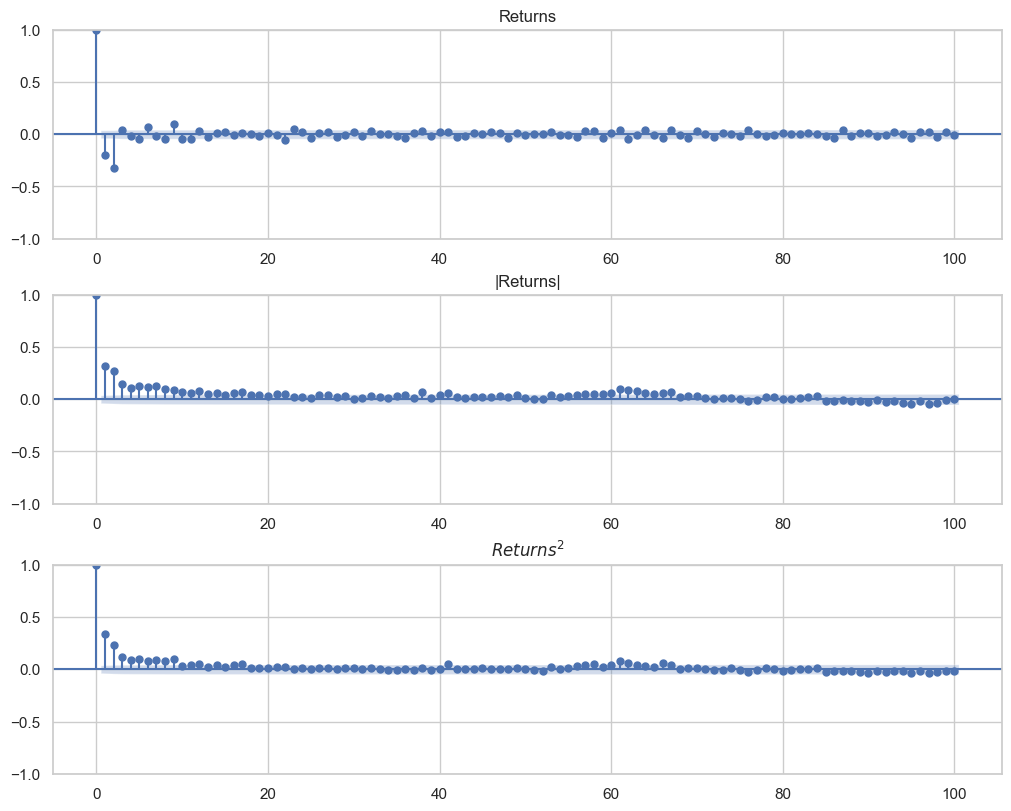

In [151]:
# ACF of residuals, abs residuals and squared residuals within GJR-GARCH

# Extract residuals
res_std = fit_gjr_std.resid
res_std = res_std[~np.isnan(res_std)]  # Remove any NaNs

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True)

plot_acf(res_std, lags=100, ax=axs[0])
axs[0].set_title("Returns")

plot_acf(np.abs(res_std), lags=100, ax=axs[1])
axs[1].set_title("|Returns|")

plot_acf(res_std**2, lags=100, ax=axs[2])
axs[2].set_title(r"$Returns^2$")

# Save figure

output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)
plt.savefig(f"{output_folder}/ACF_PACF_GJR_GARCH_.png", dpi=300)

plt.show()

In [152]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(res_std, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test) #H0: lack of autocorrelation

          lb_stat    lb_pvalue
5  416.6169095777 0.0000000000
10 470.7598699154 0.0000000000
15 482.1078870309 0.0000000000
20 484.2257608411 0.0000000000
25 503.8134057421 0.0000000000


In [153]:
#Ljung-Box test for autocorrelation of each kind of residuals
# Ljung-Box test (raw residuals)
ljung_raw = acorr_ljungbox(res_std, lags=[10, 20], return_df=True)

# Ljung-Box test (absolute residuals)
ljung_abs = acorr_ljungbox(np.abs(res_std), lags=[10, 20], return_df=True)

# Ljung-Box test (squared residuals)
ljung_sq = acorr_ljungbox(res_std**2, lags=[10, 20], return_df=True)

# Display results
print("Ljung-Box Test on Standardized Residuals")
print(ljung_raw, '\n')

print("Ljung-Box Test on Absolute Standardized Residuals")
print(ljung_abs, '\n')

print("Ljung-Box Test on Squared Standardized Residuals")
print(ljung_sq)


Ljung-Box Test on Standardized Residuals
          lb_stat    lb_pvalue
10 470.7598699154 0.0000000000
20 484.2257608411 0.0000000000 

Ljung-Box Test on Absolute Standardized Residuals
          lb_stat    lb_pvalue
10 767.8698091969 0.0000000000
20 853.2999228792 0.0000000000 

Ljung-Box Test on Squared Standardized Residuals
          lb_stat    lb_pvalue
10 624.1416376108 0.0000000000
20 654.3508743686 0.0000000000


In [154]:
models = [model_gjr_std, model_gjr] # list with all the models
names = ['GJR-GARCH with std. res.', 'GJR-GARCH with t-stud res.'] # models' names

# Fit models and collect info
results = []

for model, name in zip(models, names):
    fit = model.fit(disp='off')
    results.append([name, round(fit.aic, 4), round(fit.bic, 4)])

# Create DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'AIC', 'BIC'])

print("Models sorted by AIC:")
print(results_df.sort_values('AIC'))

print("\nModels sorted by BIC:")
print(results_df.sort_values('BIC'))

Models sorted by AIC:
                        Model              AIC              BIC
1  GJR-GARCH with t-stud res. 12078.2119000000 12119.6880000000
0    GJR-GARCH with std. res. 12339.5373000000 12375.0882000000

Models sorted by BIC:
                        Model              AIC              BIC
1  GJR-GARCH with t-stud res. 12078.2119000000 12119.6880000000
0    GJR-GARCH with std. res. 12339.5373000000 12375.0882000000


In [155]:
# ARCH test: t-student residuals model
# Define lags to test
lags = [4, 8, 12, 16]
results = []
residuals_dict = {
    'GJR-GARCH with t-student res.': res,
    'GJR-GARCH with norm. std. res.': res_std
}

lags = [4, 8, 12, 16]

# Prepare an empty list to collect results
all_results = []

for name, z in residuals_dict.items():
    for lag in lags:
        test_stat, p_value, _, _ = het_arch(z, lag)
        all_results.append([name, lag, test_stat, p_value])

# Convert to DataFrame for easier viewing
arch_test_df = pd.DataFrame(all_results, columns=['Residuals', 'Lag', 'Test Statistic', 'p-value'])

print(arch_test_df)

                        Residuals  Lag  Test Statistic      p-value
0   GJR-GARCH with t-student res.    4  344.6542371220 0.0000000000
1   GJR-GARCH with t-student res.    8  358.7869027278 0.0000000000
2   GJR-GARCH with t-student res.   12  367.2924325922 0.0000000000
3   GJR-GARCH with t-student res.   16  369.5709034501 0.0000000000
4  GJR-GARCH with norm. std. res.    4  351.6975307808 0.0000000000
5  GJR-GARCH with norm. std. res.    8  365.7333050088 0.0000000000
6  GJR-GARCH with norm. std. res.   12  374.1477952155 0.0000000000
7  GJR-GARCH with norm. std. res.   16  376.6217150601 0.0000000000


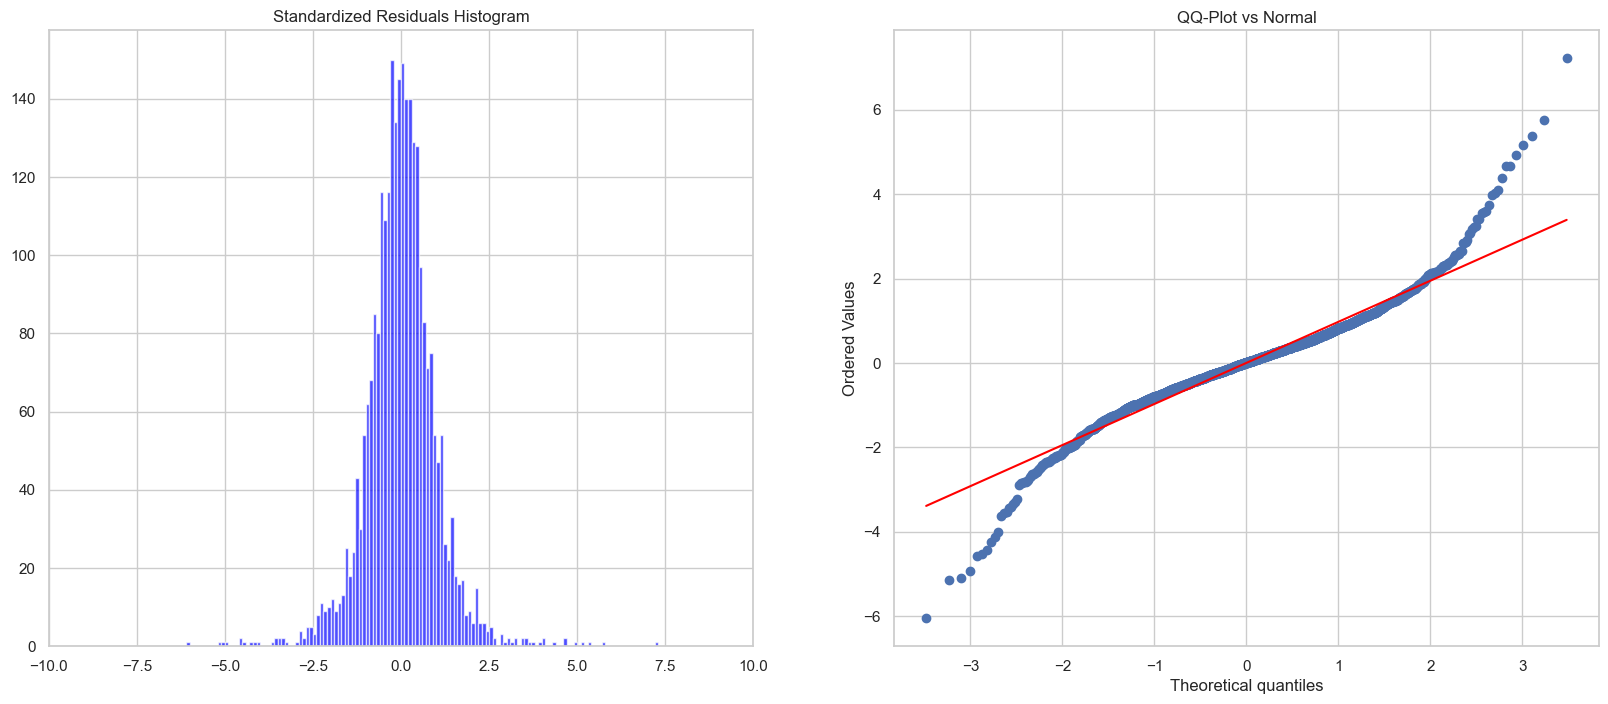

In [156]:
#GJR-GARCH with residuals from standard normal distribution
# Scale the residuals (standardize)
scaler = StandardScaler()
res_std_scaled = scaler.fit_transform(res_std.values.reshape(-1, 1)).flatten()  

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Histogram of standardized residuals
axs[0].hist(res_std_scaled, bins=200, range=(-10, 10), color='blue', alpha=0.7)
axs[0].set_title('Standardized Residuals Histogram')
axs[0].set_xlim(-10, 10)

# QQ-plot vs Normal
probplot(res_std_scaled, dist="norm", plot=axs[1])
axs[1].get_lines()[1].set_color('red')
axs[1].set_title("QQ-Plot vs Normal")

# Save figure
output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)
plt.savefig(f"{output_folder}/Hist_and_QQ_returns_GJR_std.png", dpi=300)
plt.show()

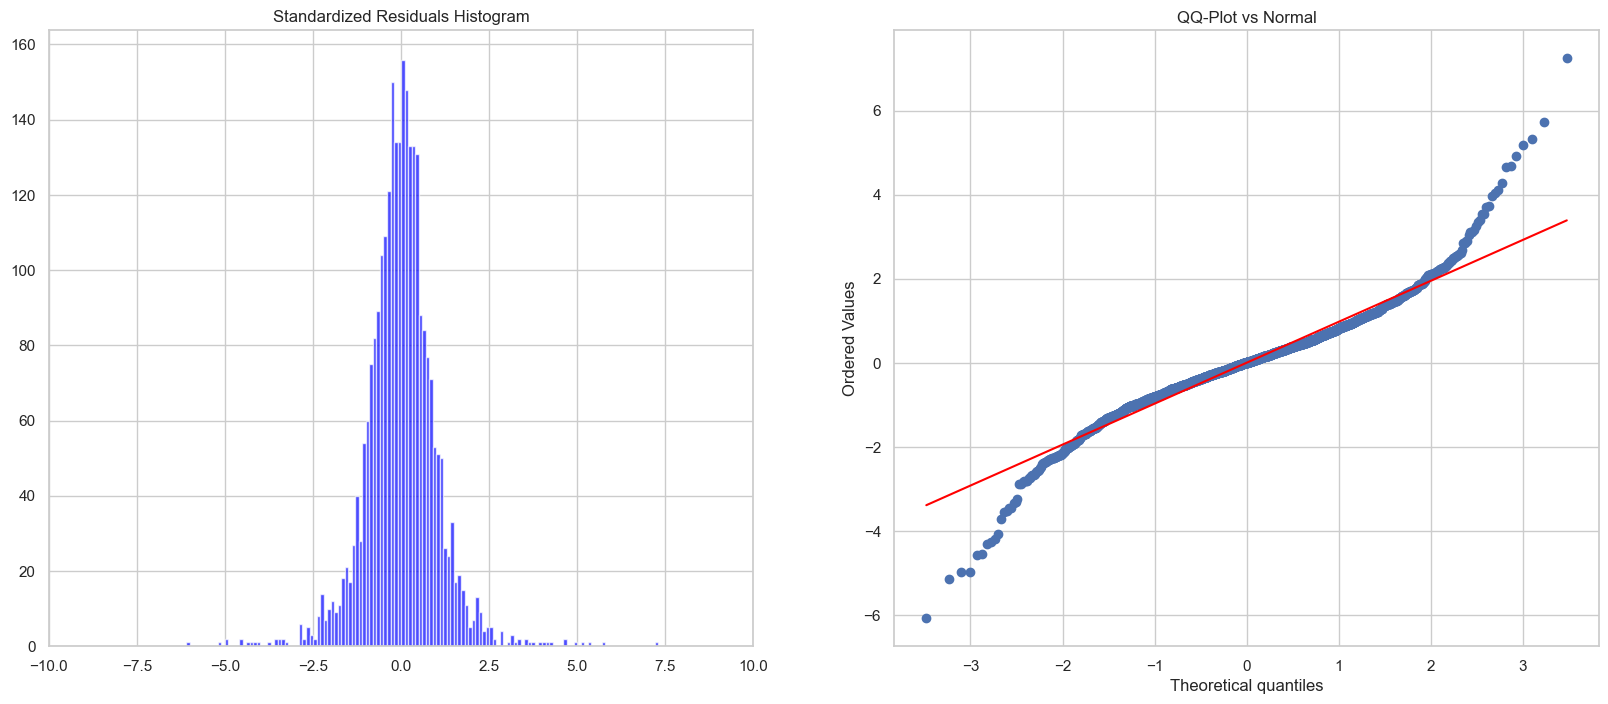

In [157]:
#GJR-GARCH with residuals from t-student distribution
# Scale the residuals (standardize)
scaler = StandardScaler()
res_scaled = scaler.fit_transform(res.values.reshape(-1, 1)).flatten()  

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Histogram of standardized residuals
axs[0].hist(res_scaled, bins=200, range=(-10, 10), color='blue', alpha=0.7)
axs[0].set_title('Standardized Residuals Histogram')
axs[0].set_xlim(-10, 10)

# QQ-plot vs Normal
probplot(res_scaled, dist="norm", plot=axs[1])
axs[1].get_lines()[1].set_color('red')
axs[1].set_title("QQ-Plot vs Normal")

# Save figure
plt.show()

In [158]:
#Leverage check for model with standard normal residual

# Create dummy variable: 1 if residual < 0 else 0
D = (z < 0).astype(int)

# Dependent variable: squared residuals
y = res_std**2

# Add constant to regressors
X = sm.add_constant(D)

# Run OLS regression: y = beta0 + beta1*D + error
model = sm.OLS(y, X).fit()

print("\nSign bias test (manual implementation):\n")
print(model.summary())


Sign bias test (manual implementation):

                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.04712
Date:                Mon, 02 Jun 2025   Prob (F-statistic):              0.828
Time:                        11:41:32   Log-Likelihood:                -11555.
No. Observations:                2766   AIC:                         2.311e+04
Df Residuals:                    2764   BIC:                         2.313e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

In [159]:
#Leverage check for model with t-student residual

# Create dummy variable: 1 if residual < 0 else 0
D = (z < 0).astype(int)

# Dependent variable: squared residuals
y = res**2

# Add constant to regressors
X = sm.add_constant(D)

# Run OLS regression: y = beta0 + beta1*D + error
model = sm.OLS(y, X).fit()

print("\nSign bias test (manual implementation):\n")
print(model.summary())


Sign bias test (manual implementation):

                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.06173
Date:                Mon, 02 Jun 2025   Prob (F-statistic):              0.804
Time:                        11:41:32   Log-Likelihood:                -11555.
No. Observations:                2766   AIC:                         2.311e+04
Df Residuals:                    2764   BIC:                         2.313e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

Interpretation:
Similarily to sGARCH and TGARCH framework, The coefficient on x1 is not statistically significant for assumed p > 0.05, meaning:

No evidence that negative shocks have a different impact on conditional variance than positive shocks for both models (GJR-GARCH with standard normal residuals and t-student residuals).

Therefore, no leverage effect detected by this test!

### News Impact Curve 

In R studio, this function is implemented by newsimpact() function from TSGarch package- we tried to replicate it (by customizing a proper function that would implement proper gamma[1] parameter from GJR-GARCH, listed below) but unfortunately we failed to achieve reasonable result (potential for replication improvement)

In [160]:
print("fit1:", fit1.params)
print("fit2:", fit2.params)
print("fit_gjr:", fit_gjr.params)

fit1: Const      -0.0136101833
y[1]       -0.5260439286
omega       0.9306569625
alpha[1]    0.2764003249
beta[1]     0.5816437280
nu          5.7639887953
Name: params, dtype: float64
fit2: Const      -0.0173620441
y[1]       -0.5073976933
omega       1.1358513138
alpha[1]    0.2887322478
beta[1]     0.5425376480
Name: params, dtype: float64
fit_gjr: Const      -0.0204025684
yret[1]    -0.5256401274
omega       0.9279980613
alpha[1]    0.2634961003
gamma[1]    0.0252360423
beta[1]     0.5824490921
nu          5.7661752158
Name: params, dtype: float64


100%|██████████| 2267/2267 [00:38<00:00, 59.10it/s]


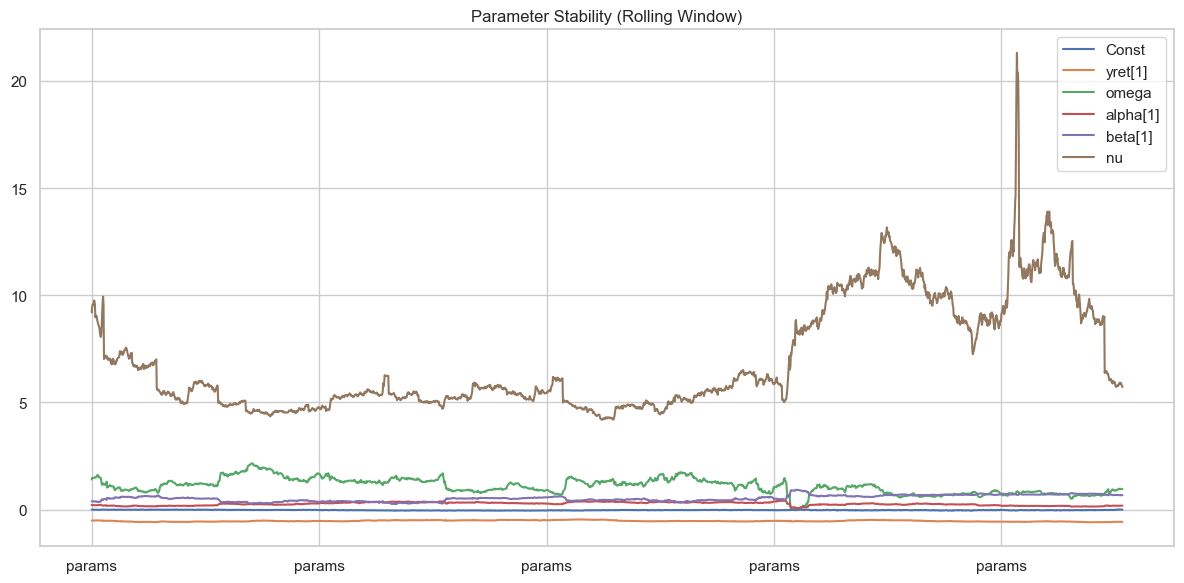

In [161]:
#Stability of parameters
window_size = 500
params_list = []

for start in tqdm(range(len(yret_clean) - window_size)):
    end = start + window_size
    sub_data = yret_clean[start:end]
    
    model = arch_model(sub_data, vol="GARCH", p=1, q=1, dist="t", mean="AR", lags=1)
    try:
        res = model.fit(disp="off")
        params_list.append(res.params)
    except Exception as e:
        print(f"Window {start}-{end} failed: {e}")
        continue

params_df = pd.DataFrame(params_list)
params_df.dropna(axis=1, how='all', inplace=True)

params_df.plot(title="Parameter Stability (Rolling Window)", figsize=(12,6))
plt.tight_layout()
plt.show()

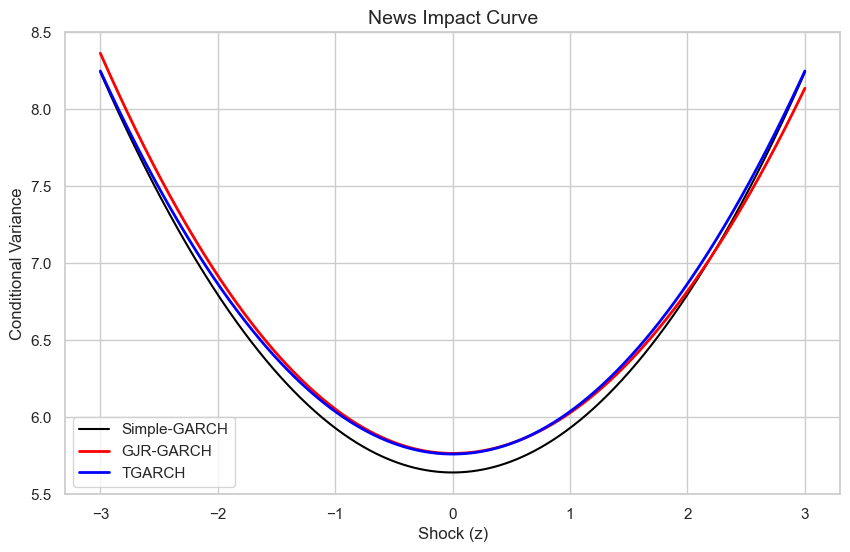

In [162]:
# Residuals shock  of occurrence
z = np.linspace(-3, 3, 500)

# === sGARCH ===
params_garch = fit2.params

omega_g = params_garch['omega']
alpha_g = params_garch['alpha[1]']
beta_g = params_garch['beta[1]']

# NIC function
nic_garch = omega_g + alpha_g * z**2 + beta_g * np.var(yret_clean)

# === GJR-GARCH ===
params_gjr = fit_gjr.params

omega_j = params_gjr['omega']
alpha_j = params_gjr['alpha[1]']
gamma_j = params_gjr['gamma[1]']  # assymetry effect
beta_j = params_gjr['beta[1]']

# NIC function
nic_gjr = omega_j + alpha_j * z**2 + gamma_j * (z < 0) * z**2 + beta_j * np.var(yret_clean)

# === TGARCH ===
params_tgarch = fit1.params

omega_t = params_tgarch['omega']
alpha_t = params_tgarch['alpha[1]']
beta_t = params_tgarch['beta[1]']

# NIC function
nic_tgarch = omega_t + alpha_t * z**2 + beta_t * np.var(yret_clean)

# === Plot of NIC ===
plt.figure(figsize=(10, 6))
plt.plot(z, nic_garch, label='Simple-GARCH', color='black')
plt.plot(z, nic_gjr, label='GJR-GARCH', color='red', linewidth=2)
plt.plot(z, nic_tgarch, label='TGARCH', color='blue', linewidth=2)
plt.title("News Impact Curve", fontsize=14)
plt.xlabel("Shock (z)", fontsize=12)
plt.ylabel("Conditional Variance", fontsize=12)

plt.ylim(5.5, 8.5)      # Limit y-axis to variances from 0 to 2


plt.legend()
plt.grid(True)
plt.show()

The NIC plots provided above allign with previous results of no significant leverage effect for each model- however, they are different from the plots provided in original research.

### I-GARCH model

In [163]:
igarch = arch_model(yret_clean, vol='GARCH', p=1, q=1, mean='Constant', dist='t')  # mean='Constant' <=> ARMA(0,0) + intercept

fit_igarch = igarch.fit(update_freq=0, disp='off')

# Number of estimated parameters
np1 = len(fit_igarch.params)

#Manual calculation of HQIC criteria (not included in the used package)
logL = fit_igarch.loglikelihood
k = len(fit_igarch.params)
n = fit_igarch.nobs

hqic = -2 * logL + 2 * k * np.log(np.log(n))

# Print information criteria
print("\nInformation Criteria")
print(f"AIC: {fit_igarch.aic}")
print(f"BIC: {fit_igarch.bic}")
print(f"HQIC: {hqic}")

# Optional: Print summary
print(fit_igarch.summary())


Information Criteria
AIC: 12802.104089779597
BIC: 12831.731684678532
HQIC: 12812.804967819873
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         yret   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6396.05
Distribution:      Standardized Student's t   AIC:                           12802.1
Method:                  Maximum Likelihood   BIC:                           12831.7
                                              No. Observations:                 2767
Date:                      Mon, Jun 02 2025   Df Residuals:                     2766
Time:                              11:42:12   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|      

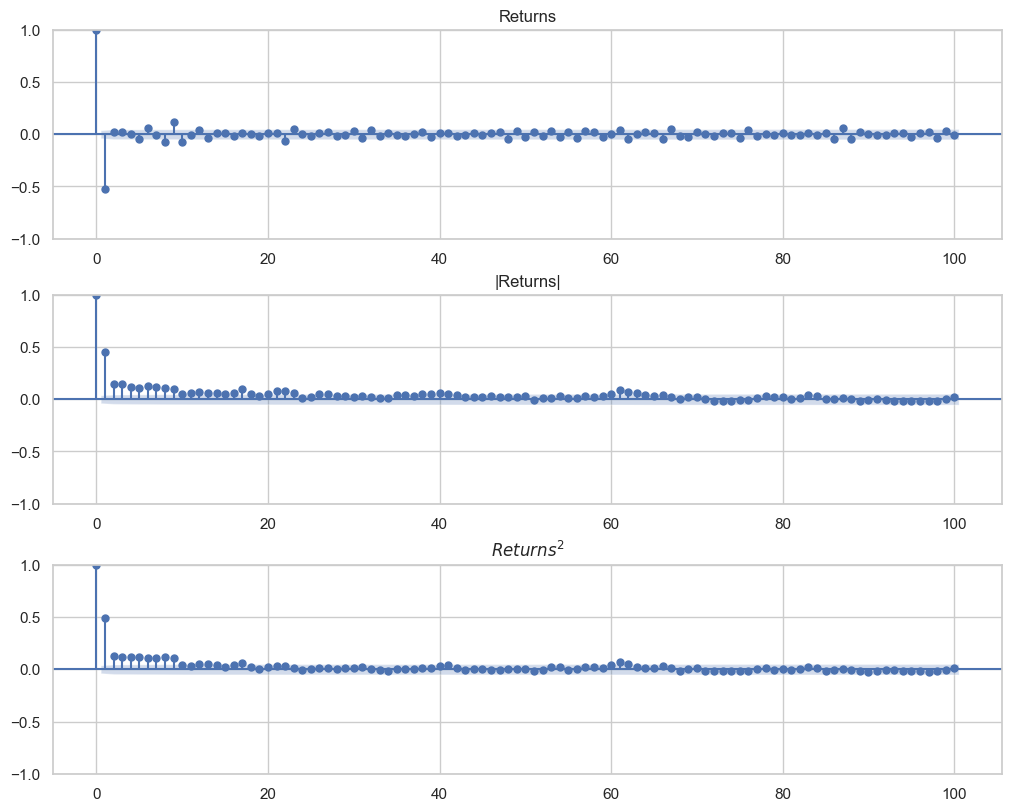

In [164]:
# ACF of residuals, abs residuals and squared residuals within ARMA(1,0) model

# Extract residuals
res = fit_igarch.resid
res = res[~np.isnan(res)]  # Remove any NaNs

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True)

plot_acf(res, lags=100, ax=axs[0])
axs[0].set_title("Returns")

plot_acf(np.abs(res), lags=100, ax=axs[1])
axs[1].set_title("|Returns|")

plot_acf(res**2, lags=100, ax=axs[2])
axs[2].set_title(r"$Returns^2$")

# Save figure
output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)
plt.savefig(f"{output_folder}/ACF_PACF_IGARCH.png", dpi=300)

plt.show()

In [165]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(res, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test) #H0: lack of autocorrelation

          lb_stat    lb_pvalue
5  771.3242038738 0.0000000000
10 847.8017124370 0.0000000000
15 856.3920861044 0.0000000000
20 858.1956269723 0.0000000000
25 877.9990108186 0.0000000000


In [166]:
#Ljung-Box test for autocorrelation of each kind of residuals
# Ljung-Box test (raw residuals)
ljung_raw = acorr_ljungbox(res, lags=[10, 20], return_df=True)

# Ljung-Box test (absolute residuals)
ljung_abs = acorr_ljungbox(np.abs(res), lags=[10, 20], return_df=True)

# Ljung-Box test (squared residuals)
ljung_sq = acorr_ljungbox(res**2, lags=[10, 20], return_df=True)

# Display results
print("Ljung-Box Test on Standardized Residuals")
print(ljung_raw, '\n')

print("Ljung-Box Test on Absolute Standardized Residuals")
print(ljung_abs, '\n')

print("Ljung-Box Test on Squared Standardized Residuals")
print(ljung_sq)

Ljung-Box Test on Standardized Residuals
          lb_stat    lb_pvalue
10 847.8017124370 0.0000000000
20 858.1956269723 0.0000000000 

Ljung-Box Test on Absolute Standardized Residuals
          lb_stat    lb_pvalue
10 888.9020712377 0.0000000000
20 988.8619139872 0.0000000000 

Ljung-Box Test on Squared Standardized Residuals
          lb_stat    lb_pvalue
10 952.0728712598 0.0000000000
20 993.1930960006 0.0000000000


In [167]:
# ARCH test: t-student residuals model
# Define lags to test
lags = [4, 8, 12, 16]
results = []
residuals_dict = {
    'IGARCH with t-student res.': res,
}

lags = [4, 8, 12, 16]

# Prepare an empty list to collect results
all_results = []

for name, z in residuals_dict.items():
    for lag in lags:
        test_stat, p_value, _, _ = het_arch(z, lag)
        all_results.append([name, lag, test_stat, p_value])

# Convert to DataFrame for easier viewing
arch_test_df = pd.DataFrame(all_results, columns=['Residuals', 'Lag', 'Test Statistic', 'p-value'])

print(arch_test_df)

                    Residuals  Lag  Test Statistic      p-value
0  IGARCH with t-student res.    4  762.8825321358 0.0000000000
1  IGARCH with t-student res.    8  784.4969085619 0.0000000000
2  IGARCH with t-student res.   12  788.5199325434 0.0000000000
3  IGARCH with t-student res.   16  789.1448886510 0.0000000000


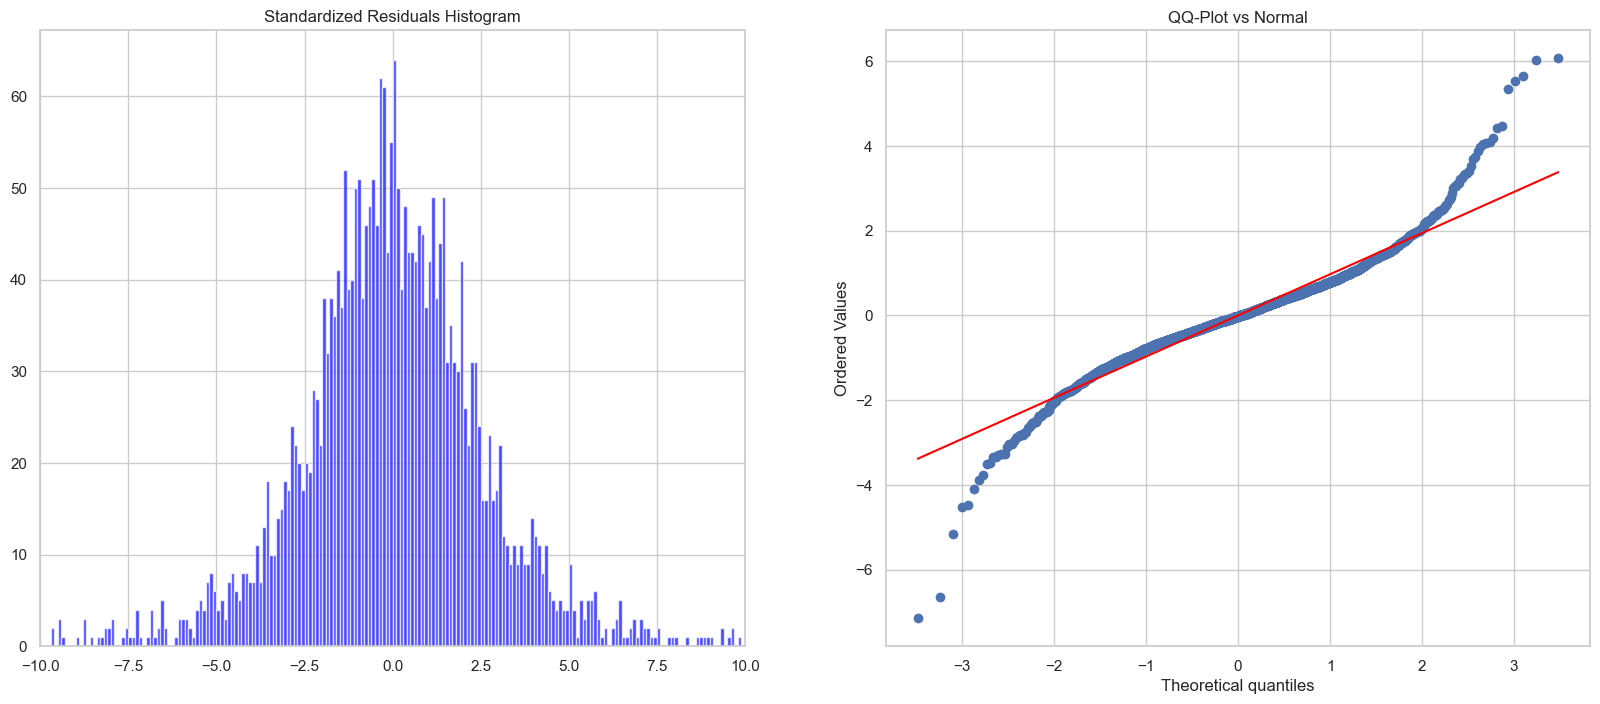

In [168]:
# Scale the residuals (standardize)
scaler = StandardScaler()
res_scaled = scaler.fit_transform(res.values.reshape(-1, 1)).flatten()

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Histogram of standardized residuals
axs[0].hist(res, bins=200, range=(-10, 10), color='blue', alpha=0.7)
axs[0].set_title('Standardized Residuals Histogram')
axs[0].set_xlim(-10, 10)

# QQ-plot vs Normal
probplot(res_scaled, dist="norm", plot=axs[1])
axs[1].get_lines()[1].set_color('red')
axs[1].set_title("QQ-Plot vs Normal")

# Save figure
output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)
plt.savefig(f"{output_folder}/Hist_and_QQ_returns_IGARCH.png", dpi=300)

In [169]:
#Leverage check

# Create dummy variable: 1 if residual < 0 else 0
D = (z < 0).astype(int)

# Dependent variable: squared residuals
y = res**2

# Add constant to regressors
X = sm.add_constant(D)

# Run OLS regression: y = beta0 + beta1*D + error
model = sm.OLS(y, X).fit()

print("\nSign bias test (manual implementation):\n")
print(model.summary())


Sign bias test (manual implementation):

                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8371
Date:                Mon, 02 Jun 2025   Prob (F-statistic):              0.360
Time:                        11:42:14   Log-Likelihood:                -12542.
No. Observations:                2767   AIC:                         2.509e+04
Df Residuals:                    2765   BIC:                         2.510e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

Interpretation:
Unlike in sGARCH and TGARCH framework, The coefficient on x1 (here as 'resid') is statistically significant for assumed p \0.05, meaning:

Negative shocks have a different impact on conditional variance than positive shocks

Therefore, leverage effect is detected by this test! (further analysis of NIC plot would be required).

### Forecasting Evaluation

In [170]:
yret_clean = df['yret'].dropna().diff().dropna()

In [171]:
y= df['gkVol'] * 100
y_clean = (df['gkVol'] * 100).dropna().diff().dropna()
time = df.index

In [172]:
y_clean

Date
2011-01-05    0.2162452158
2011-01-06   -0.4883156866
2011-01-07   -0.3593092579
2011-01-10    0.0181705939
2011-01-11    0.4926456250
                  ...     
2021-12-27   -0.5732292310
2021-12-28    1.5813775513
2021-12-29   -1.4359682310
2021-12-30   -0.0703256746
2021-12-31    0.4518727609
Name: gkVol, Length: 2767, dtype: float64

Text(0.5, 1.0, 'Garman-Klass volatility measure')

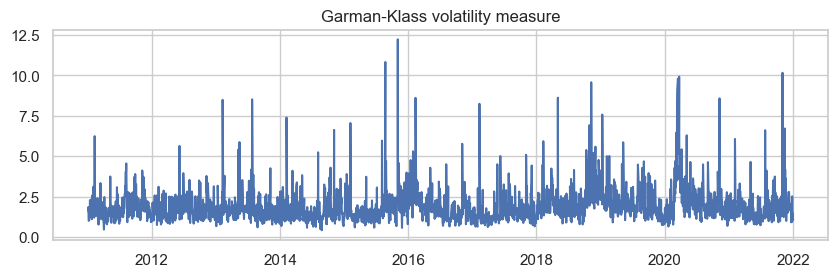

In [173]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time, y)
plt.title("Garman-Klass volatility measure")

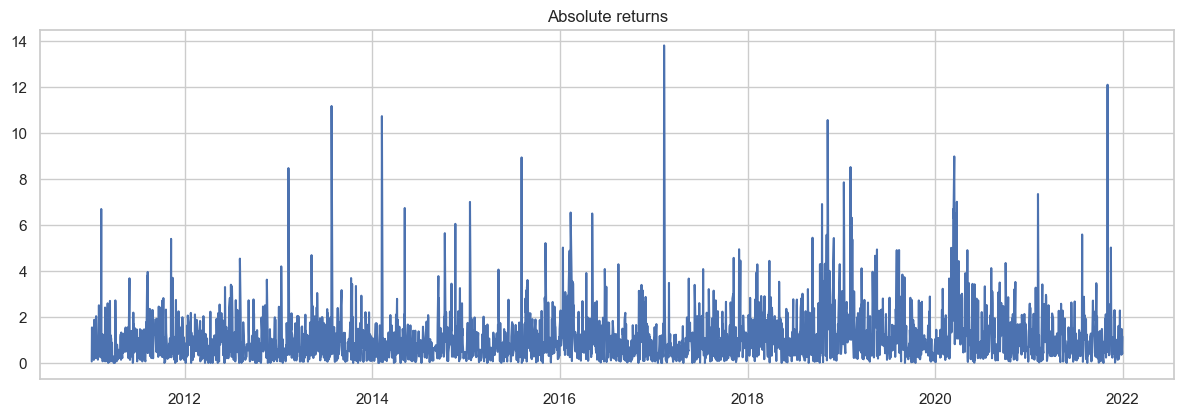

In [174]:
plt.subplot(2, 1, 2)
plt.plot(time, np.sqrt(2 / np.pi) * np.abs(yret))
plt.title("Absolute returns")
plt.tight_layout()
plt.show()

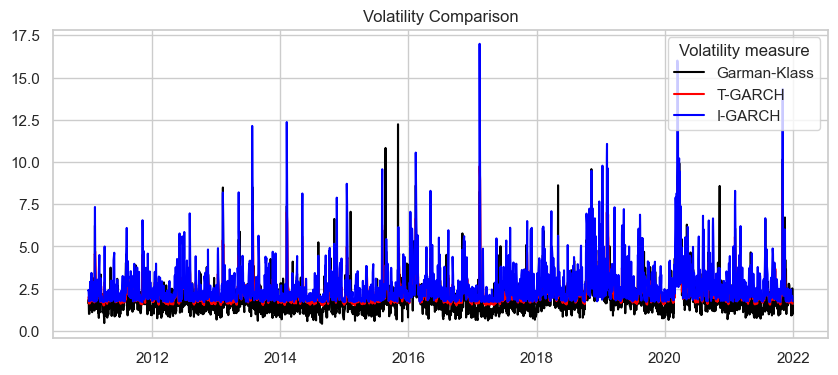

In [230]:
plt.figure(figsize=(10, 4))
plt.plot(time, y, label='Garman-Klass', color='black')
plt.plot(time[:len(fit1.conditional_volatility)], fit1.conditional_volatility, label='T-GARCH', color='red')
plt.plot(time[:len(fit_igarch.conditional_volatility)], fit_igarch.conditional_volatility, label='I-GARCH', color='blue')
plt.legend(loc="upper right", title="Volatility measure")
plt.title("Volatility Comparison")
plt.show()

In [228]:
naive_vol = np.std(yret)
naive_var = naive_vol ** 2

In [182]:
from TSA_Predict_Functions import error_measures, extract_model_info

In [236]:
# --- Error Measures ---
print("-" * 70)
print("Error measures")

ErrorMeas = []
models = [fit2, fit_gjr, fit1, fit_igarch]
model_names = ["GARCH", "GJR-GARCH", "T-GARCH", "IGARCH"]

for i, model in enumerate(models):
    sigma=model.conditional_volatility
    vol_metrics = error_measures(yret_clean, sigma, naive_vol)
    var_metrics = error_measures(yret_clean**2, model.conditional_volatility*2, naive_var)
    ErrorMeas.append({"measure": "Volatility", "model": model_names[i], **vol_metrics})
    ErrorMeas.append({"measure": "Variance", "model": model_names[i], **var_metrics})

ErrorMeas_df = pd.DataFrame(ErrorMeas)
print(ErrorMeas_df)

----------------------------------------------------------------------
Error measures
      measure      model            ME          MAE          RMSE   MPE  MAPE RMSPE        ScMAE       ScRMSE
0  Volatility      GARCH -2.3516949365 2.8872782265  3.8258233785  None  None  None 1.0654676710 1.0955718459
1    Variance      GARCH  3.6024084240 7.7131059261 22.0297856534  None  None  None 0.9849650176 0.9603440995
2  Volatility  GJR-GARCH -2.3263400465 2.8681879386  3.8054378145  None  None  None 1.0584229448 1.0897341875
3    Variance  GJR-GARCH  3.6531182039 7.7024907357 22.0464667612  None  None  None 0.9836094559 0.9610712788
4  Volatility    T-GARCH -2.3265489686 2.8730084221  3.8146283708  None  None  None 1.0602018067 1.0923660169
5    Variance    T-GARCH  3.6527003598 7.7032789939 22.0444003273  None  None  None 0.9837101166 0.9609811968
6  Volatility     IGARCH -2.6973977675 3.1192012264  4.1903635693  None  None  None 1.1510522386 1.1999624385
7    Variance     IGARCH  2.910922

In [267]:
# === Diebold-Mariano Test ===
from TSA_Predict_Functions import diebold_mariano  # Replace with actual import or paste function

h = 1
errors = {
    "e1": yret_clean - fit2.conditional_volatility,
    "e2": yret_clean - fit_gjr.conditional_volatility,
    "e5": yret_clean - fit1.conditional_volatility,
    "e6": yret_clean - fit_igarch.conditional_volatility
}
print("DM Test Results:")
diebold_mariano(e1=errors["e1"].dropna(), e2=errors["e2"].dropna(), h=h, power=1, msg="GARCH vs GJR-GARCH ->")
diebold_mariano(e1=errors["e1"].dropna(), e2=errors["e2"].dropna(), h=h, power=2, msg="GARCH vs GJR-GARCH ->")
diebold_mariano(e1=errors["e1"].dropna(), e2=errors["e6"].dropna()[:len(errors["e1"].dropna())], h=h, power=1, msg="GARCH vs IGARCH    ->")
diebold_mariano(e1=errors["e1"].dropna(), e2=errors["e6"].dropna()[:len(errors["e1"].dropna())], h=h, power=2, msg="GARCH vs IGARCH    ->")



DM Test Results:
GARCH vs GJR-GARCH -> Horizon: 1, Power: 1, DM Statistic: 16.3925, p-value: 0.0000
GARCH vs GJR-GARCH -> Horizon: 1, Power: 2, DM Statistic: 9.3495, p-value: 0.0000
GARCH vs IGARCH    -> Horizon: 1, Power: 1, DM Statistic: -3.3389, p-value: 0.0008
GARCH vs IGARCH    -> Horizon: 1, Power: 2, DM Statistic: -2.8462, p-value: 0.0044


{'statistic': np.float64(-2.846169541241241),
 'p_value': np.float64(0.004424862921645678),
 'horizon': 1,
 'power': 2}

In [258]:
e1_var = yret_clean**2 - fit2.conditional_volatility**2
e2_var = yret_clean**2 - fit_gjr.conditional_volatility**2
e5_var = yret_clean**2 - fit1.conditional_volatility**2
e6_var = yret_clean**2 - fit_igarch.conditional_volatility**2

diebold_mariano(e1_var.dropna(), e2_var.dropna(), h, power=1, msg="GARCH vs GJR-GARCH ->")
diebold_mariano(e1_var.dropna(), e2_var.dropna(), h, power=2, msg="GARCH vs GJR-GARCH ->")
diebold_mariano(e2_var.dropna(), e5_var.dropna(), h, power=1, msg="GJR-GARCH vs T-GARCH ->")
diebold_mariano(e1_var.dropna(), e5_var.dropna(), h, power=2, msg="GARCH vs T-GARCH ->")
diebold_mariano(e1_var.dropna(), e6_var.dropna()[:len(e1_var.dropna())], h, power=1, msg="GARCH vs IGARCH ->")
diebold_mariano(e1_var.dropna(), e6_var.dropna()[:len(e1_var.dropna())], h, power=2, msg="GARCH vs IGARCH ->")


GARCH vs GJR-GARCH -> Horizon: 1, Power: 1, DM Statistic: -1.6774, p-value: 0.0935
GARCH vs GJR-GARCH -> Horizon: 1, Power: 2, DM Statistic: -2.2525, p-value: 0.0243
GJR-GARCH vs T-GARCH -> Horizon: 1, Power: 1, DM Statistic: -0.1093, p-value: 0.9130
GARCH vs T-GARCH -> Horizon: 1, Power: 2, DM Statistic: -3.4765, p-value: 0.0005
GARCH vs IGARCH -> Horizon: 1, Power: 1, DM Statistic: -2.7904, p-value: 0.0053
GARCH vs IGARCH -> Horizon: 1, Power: 2, DM Statistic: -0.3769, p-value: 0.7063


{'statistic': np.float64(-0.3768567721453786),
 'p_value': np.float64(0.7062800477284616),
 'horizon': 1,
 'power': 2}